# Introduction

Keep the key plots.

In [2]:
import sys, os
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import partial
#path_to_repo="/n/projects/mw2098/publications/2024_weilert_acc/public/software/rosamc/GeneRegulatoryFunctions/utilsGRF/"

import matplotlib.pyplot as plt
#matplotlib.use('Agg') 
import plotnine
from plotnine import *

#sys.path.insert(0, path_to_repo)
import time

#import writescripts 
#import BoundaryFinder as BF
from scipy.linalg import null_space

figure_filepath = './figures/18_simulate_kinetics'
!mkdir -p {figure_filepath}


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/rosamartinezcorral/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/rosamartinezcorral/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/rosamartinezcorral/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/rosamartinezcorral/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/applicat

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/rosamartinezcorral/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/rosamartinezcorral/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/rosamartinezcorral/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/rosamartinezcorral/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/applicat

AttributeError: _ARRAY_API not found

## Adjacent packages

In [3]:
# ! pip install sympy
# ! pip install latex

# Investigate p(open) and acc.

# Design simulation functions

In [4]:

#model with 2 sites, 2 conformations
def L_2TFs_2c(pars,A=1,B=1): #A:A, B:B
    aA_0_0,aA_0_1,bA_A_0,bA_A_1,aB_0_0,aB_0_1,bB_B_0,bB_B_1,aB_A_0,aB_A_1,bB_AB_0,bB_AB_1,aA_B_0,aA_B_1,bA_AB_0,bA_AB_1,kopen0,kclose0,kopenA,kcloseA,kopenB,kcloseB,kopenAB,kcloseAB=pars
    L=np.array([
    [0,aA_0_0*A,aB_0_0*B,0,kopen0,0,0,0], #1->1, 1->2, 1->3, 1->4, 1->5, 1->6, 1->7, 1->8  (input node, target node)
    [bA_A_0,0,0,aB_A_0*B,0,kopenA,0,0],   #2->1
    [bB_B_0,0,0,aA_B_0*A,0,0,kopenB,0],
    [0,bB_AB_0,bA_AB_0,0,0,0,0,kopenAB],
    [kclose0,0,0,0,0,aA_0_1*A,aB_0_1*B,0],
    [0,kcloseA,0,0,bA_A_1,0,0,aB_A_1*B],
    [0,0,kcloseB,0,bB_B_1,0,0,aA_B_1*A],
    [0,0,0,kcloseAB,0,bB_AB_1,bA_AB_1,0]
    ])
    return L.transpose() #we want (target node, input node)

#model with 1 sites, 2 conformations
def L_1TF_2c(pars,A=1,B=1): #A:A, B:B
    aA_0_0,aA_0_1,bA_A_0,bA_A_1,kopen0,kclose0,kopenA,kcloseA=pars
    L=np.array([
    [0,aA_0_0*A,kopen0,0], #1->1, 1->2, 1->3, 1->4 (input node, target node)
    [bA_A_0,0,0,kopenA],   #2->1
    [kclose0,0,0,aA_0_1*A], #3->1
    [0,kcloseA,bA_A_1,0]
    ])
    return L.transpose() #we want (target node, input node)


def compute_ss_fromL(L,verbose=False):
    L_d=np.diag(np.sum(L,axis=0)) #calculate the diagonal array after summing L
    
    if verbose:
        print("L",L)
        print("L_d",L_d)
    L=L-L_d
    rhos=null_space(L) #column vector
    if verbose:
        print("rhos", rhos)
        print("rhos*L", L@rhos)
    rhos=np.transpose(rhos)[0] #1 row
    
    ss=np.abs(rhos)/np.sum(np.abs(rhos)) #can be - when very close to 0
    
    return ss

def get_Popen(parset,idx_openconc=4,Lfunc=None,A=1,B=1,verbose=False):
    L=Lfunc(parset, A=A, B=B)
    ssvec=compute_ss_fromL(L,verbose=verbose)
    ssvec_open=np.sum(ssvec[idx_openconc:])
    if verbose:
        print("steady states:", ssvec)
        print("steady state sum:", np.sum(ssvec))
        print("open:", ssvec_open)
    return ssvec_open

def get_Pbound(parset, Lfunc=None, A=1,B=1,verbose=False,idxs_bound=None):
    L=Lfunc(parset,A=A, B=B)
    ssvec=compute_ss_fromL(L,verbose=verbose)
    ssvec_bound=np.sum(ssvec[idxs_bound])
    
    if verbose:
        print("steady states:", ssvec)
        print("steady state sum:", np.sum(ssvec))
        print("bound:", ssvec_bound)
    
    return ssvec_bound



In [5]:
def model_2TFs_reference_nakednomotif(parset, idx_openconc=4, Lfunc=None, returnb=False, idxs_bound=None):
    #high affinity: higher affinity difference between naked-no motif and naked-motif
    
    konA,konB,koff1nA,koff1nB,gA,gB,betanA, betanB, betamA, betamB,h0,h1, kopen0,kclose0, a1nA, a1nB, a1nAB, a1mA, a1mB, a1mAnB, a1nAmB, a1mAmB, a2nA, a2nB, a2nAB, a2mA, a2mB, a2mAnB, a2nAmB, a2mAmB=parset
    
    #same for all
    aA_0_0=konA
    aA_0_1=konA
    aA_B_0=konA
    aA_B_1=konA
    aB_0_0=konB
    aB_0_1=konB
    aB_A_0=konB
    aB_A_1=konB
    
    
    
    #no motif system
    bA_A_1=koff1nA #off-rate open conformation without motif
    bA_A_0=betanA*bA_A_1
    
    bB_B_1=koff1nB
    bB_B_0=betanB*bB_B_1
    
    bA_AB_0=h0*bA_A_0
    bA_AB_1=h1*bA_A_1
    
    bB_AB_0=h0*bB_B_0
    bB_AB_1=h1*bB_B_1
    
    kopenA=a1nA*kopen0
    kopenB=a1nB*kopen0
    kopenAB=a1nAB*kopen0
    
    kcloseA=kclose0*a2nA
    kcloseB=kclose0*a2nB
    kcloseAB=kclose0*a2nAB
    
    
    parset_n=[aA_0_0,aA_0_1,bA_A_0,bA_A_1,aB_0_0,aB_0_1,bB_B_0,bB_B_1,aB_A_0,aB_A_1,bB_AB_0,bB_AB_1,aA_B_0,aA_B_1,bA_AB_0,bA_AB_1,kopen0,kclose0,kopenA,kcloseA,kopenB,kcloseB,kopenAB,kcloseAB]
    #A only motif system
    bA_A_1=gA*koff1nA
    bA_A_0=betamA*bA_A_1
    
    bB_B_1=koff1nB
    bB_B_0=betanB*bB_B_1
    
    bA_AB_0=h0*bA_A_0
    bA_AB_1=h1*bA_A_1
    
    bB_AB_0=h0*bB_B_0
    bB_AB_1=h1*bB_B_1
    
    kopenA=a1mA*kopen0
    kopenB=a1nB*kopen0
    kopenAB=a1mAnB*kopen0
    kcloseA=kclose0*a2mA
    kcloseB=kclose0*a2nB
    kcloseAB=kclose0*a2mAnB
    
    
    parset_A=[aA_0_0,aA_0_1,bA_A_0,bA_A_1,aB_0_0,aB_0_1,bB_B_0,bB_B_1,aB_A_0,aB_A_1,bB_AB_0,bB_AB_1,aA_B_0,aA_B_1,bA_AB_0,bA_AB_1,kopen0,kclose0,kopenA,kcloseA,kopenB,kcloseB,kopenAB,kcloseAB]

    #B only motif system
    bA_A_1=koff1nA
    bA_A_0=betanA*bA_A_1
    
    bB_B_1=gB*koff1nB
    bB_B_0=betamB*bB_B_1
    
    bA_AB_0=h0*bA_A_0
    bA_AB_1=h1*bA_A_1
    
    bB_AB_0=h0*bB_B_0
    bB_AB_1=h1*bB_B_1
    
    kopenA=a1nA*kopen0
    kopenB=a1mB*kopen0
    kopenAB=a1nAmB*kopen0
    kcloseA=kclose0*a2nA
    kcloseB=kclose0*a2mB
    kcloseAB=kclose0*a2nAmB
    
    
    parset_B=[aA_0_0,aA_0_1,bA_A_0,bA_A_1,aB_0_0,aB_0_1,bB_B_0,bB_B_1,aB_A_0,aB_A_1,bB_AB_0,bB_AB_1,aA_B_0,aA_B_1,bA_AB_0,bA_AB_1,kopen0,kclose0,kopenA,kcloseA,kopenB,kcloseB,kopenAB,kcloseAB]

    
    #AB motif system
    bA_A_1=gA*koff1nA
    bA_A_0=betamA*bA_A_1
    
    bB_B_1=gB*koff1nB
    bB_B_0=betamB*bB_B_1
    
    bA_AB_0=h0*bA_A_0
    bA_AB_1=h1*bA_A_1
    
    bB_AB_0=h0*bB_B_0
    bB_AB_1=h1*bB_B_1
    
    kopenA=a1mA*kopen0
    kopenB=a1mB*kopen0
    kopenAB=a1mAmB*kopen0
    kcloseA=kclose0*a2mA
    kcloseB=kclose0*a2mB
    kcloseAB=kclose0*a2mAmB
    
    
    parset_AB=[aA_0_0,aA_0_1,bA_A_0,bA_A_1,aB_0_0,aB_0_1,bB_B_0,bB_B_1,aB_A_0,aB_A_1,bB_AB_0,bB_AB_1,aA_B_0,aA_B_1,bA_AB_0,bA_AB_1,kopen0,kclose0,kopenA,kcloseA,kopenB,kcloseB,kopenAB,kcloseAB]

  
    
    A_0=get_Popen(parset_n,Lfunc=Lfunc,idx_openconc=idx_openconc)
    A_A=get_Popen(parset_A,Lfunc=Lfunc,idx_openconc=idx_openconc)
    A_B=get_Popen(parset_B,Lfunc=Lfunc,idx_openconc=idx_openconc)
    A_AB=get_Popen(parset_AB,Lfunc=Lfunc,idx_openconc=idx_openconc)
    if returnb:
        b_0=get_Pbound(parset_n,Lfunc=Lfunc,idxs_bound=idxs_bound)
        b_A=get_Pbound(parset_A,Lfunc=Lfunc,idxs_bound=idxs_bound)
        b_B=get_Pbound(parset_B,Lfunc=Lfunc,idxs_bound=idxs_bound)
        b_AB=get_Pbound(parset_AB,Lfunc=Lfunc,idxs_bound=idxs_bound)
        idxs_boundB=[idxs_bound[0]+1,idxs_bound[1],idxs_bound[2]+1,idxs_bound[3]]
        bB_0=get_Pbound(parset_n,Lfunc=Lfunc,idxs_bound=idxs_boundB)
        bB_A=get_Pbound(parset_A,Lfunc=Lfunc,idxs_bound=idxs_boundB)
        bB_B=get_Pbound(parset_B,Lfunc=Lfunc,idxs_bound=idxs_boundB)
        bB_AB=get_Pbound(parset_AB,Lfunc=Lfunc,idxs_bound=idxs_boundB)
        return [A_0, A_A, A_B, A_AB, b_0, b_A, b_B, b_AB,bB_0, bB_A, bB_B, bB_AB]
    else:    
        return [A_0, A_A, A_B, A_AB]
    
def model_2TFs_equilibrium(parset):
    #high affinity: higher affinity difference between naked-no motif and naked-motif
    
    #konA,konB,koff1nA,koff1nB,gA,gB,betanA, betanB, betamA, betamB,h0,h1, kopen0,kclose0, a1nA, a1nB, a1nAB, a1mA, a1mB, a1mAnB, a1nAmB, a1mAmB, a1nA, a1nB, a1nAB, a1mA, a1mB, a1mAnB, a1nAmB, a1mAmB, a2nA, a2nB, a2nAB, a2mA, a2mB, a2mAnB, a2nAmB, a2mAmB=parset
    konA,konB,koff1nA,koff1nB,gA,gB,betanA, betanB, betamA, betamB,h0,h1, kopen0,kclose0, a1nA, a1nB, a1nAB, a1mA, a1mB, a1mAnB, a1nAmB, a1mAmB, a2nA, a2nB, a2nAB, a2mA, a2mB, a2mAnB, a2nAmB, a2mAmB=parset
    #assumes A=1
    #nomotif
    K0A=konA/(koff1nA*betanA)
    K1A=konA/koff1nA
    K0B=konB/(koff1nB*betanB)
    K1B=konB/(koff1nB)
    w0=1/h0
    w1=1/h1
    d=kopen0/kclose0
    
    mu1=1
    mu2=K0A
    mu3=K0B
    mu4=K0A*K0B*w0
    mu5=d
    mu6=d*K1A
    mu7=d*K1B
    mu8=d*K1A*K1B*w1
    Z=mu1+mu2+mu3+mu4+mu5+mu6+mu7+mu8
    ssvec=np.array([mu1,mu2,mu3,mu4,mu5,mu6,mu7,mu8])/Z
    A_0=np.sum(ssvec[4:])
    b_0=np.sum(ssvec[[1,3,5,7]]) #binding of A
    bB_0=np.sum(ssvec[[2,3,6,7]]) #binding of B
    
    #Amotif
    K0A=konA/(koff1nA*betamA*gA)
    K1A=konA/(koff1nA*gA)
    K0B=konB/(koff1nB*betanB)
    K1B=konB/(koff1nB)
    w0=1/h0
    w1=1/h1
    d=kopen0/kclose0
    
    mu1=1
    mu2=K0A
    mu3=K0B
    mu4=K0A*K0B*w0
    mu5=d
    mu6=d*K1A
    mu7=d*K1B
    mu8=d*K1A*K1B*w1
    Z=mu1+mu2+mu3+mu4+mu5+mu6+mu7+mu8
    ssvec=np.array([mu1,mu2,mu3,mu4,mu5,mu6,mu7,mu8])/Z
    A_A=np.sum(ssvec[4:])
    b_A=np.sum(ssvec[[1,3,5,7]]) #binding of A
    bB_A=np.sum(ssvec[[2,3,6,7]]) #binding of B
    
    
    #Bmotif
    K0A=konA/(koff1nA*betanA)
    K1A=konA/(koff1nA)
    K0B=konB/(koff1nB*betamB*gB)
    K1B=konB/(koff1nB*gB)
    w0=1/h0
    w1=1/h1
    d=kopen0/kclose0
    
    mu1=1
    mu2=K0A
    mu3=K0B
    mu4=K0A*K0B*w0
    mu5=d
    mu6=d*K1A
    mu7=d*K1B
    mu8=d*K1A*K1B*w1
    Z=mu1+mu2+mu3+mu4+mu5+mu6+mu7+mu8
    ssvec=np.array([mu1,mu2,mu3,mu4,mu5,mu6,mu7,mu8])/Z
    A_B=np.sum(ssvec[4:])
    b_B=np.sum(ssvec[[1,3,5,7]]) #binding of A
    bB_B=np.sum(ssvec[[2,3,6,7]]) #binding of B
    
    #ABmotif
    K0A=konA/(koff1nA*betamA*gA)
    K1A=konA/(koff1nA*gA)
    K0B=konB/(koff1nB*betamB*gB)
    K1B=konB/(koff1nB*gB)
    w0=1/h0
    w1=1/h1
    d=kopen0/kclose0
    
    mu1=1
    mu2=K0A
    mu3=K0B
    mu4=K0A*K0B*w0
    mu5=d
    mu6=d*K1A
    mu7=d*K1B
    mu8=d*K1A*K1B*w1
    Z=mu1+mu2+mu3+mu4+mu5+mu6+mu7+mu8
    ssvec=np.array([mu1,mu2,mu3,mu4,mu5,mu6,mu7,mu8])/Z
    A_AB=np.sum(ssvec[4:])
    b_AB=np.sum(ssvec[[1,3,5,7]]) #binding of A
    bB_AB=np.sum(ssvec[[2,3,6,7]]) #binding of B
    
    
    return [A_0, A_A, A_B, A_AB, b_0, b_A, b_B, b_AB, bB_0, bB_A, bB_B, bB_AB]
    
def plot_parset_2TFs(parset,idx_openconc=4,Lfunc=None,namesave=None, modelfunc=model_2TFs_reference_nakednomotif, exprel=False, a=1, b=1):
    
    A_0, A_A, A_B, A_AB=modelfunc(parset, idx_openconc=idx_openconc, Lfunc=Lfunc)
    if exprel:
        newAvals=[]
        Popenvals=[A_0, A_A, A_B, A_AB]
        for i in range(len(Popenvals)):
            newAvals.append(from_Popen_to_atac(Popenvals[i],a=a,b=b))
        A_0, A_A, A_B, A_AB = newAvals
        
    print(A_0, A_A, A_B, A_AB)
    fA=A_A/A_0
    fB=A_B/A_0
    fAB=A_AB/A_0
    fig,axes=plt.subplots(1,3,figsize=(12,4))
    ax=axes[0]
    ax.bar(range(4),[A_0, A_A, A_B, A_AB],width=0.5,color="gray")
    if not exprel:
        ax.set_ylabel("P(open) (accessibility)")
    else:
        ax.set_ylabel("ATAC")
    ax2=ax.twinx()
    ax2.bar(np.arange(4)+0.5,[1,A_A/A_0, A_B/A_0, A_AB/A_0],color="k",width=0.5)
    ax2.set_ylabel("$f_X$")
    ax.set_xticks(range(4))
    ax.set_xticklabels(["$A_\emptyset$", "$A_A$", "$A_B$", "$A_{A,B}$"])
    ax2.axhline(y=1,linestyle="--",color="gray")
    
    ax=axes[1]
    ax.scatter(fA*fB, fAB)
    ax.set_xlabel(r"$f_A \times f_B$")
    ax.set_ylabel("$f_{A,B}$")
    ax.axline((0,0), slope=1,color="gray")
    
    ax=axes[2]
    ax.scatter(A_A-A_0+A_B-A_0,A_AB-A_0)
    ax.set_xlabel("A+B-2null")
    ax.set_ylabel("AB-null")
    coopval=np.log((A_AB-A_0)/(A_A-A_0+A_B-A_0))
    ax.set_title("coop=%g"%coopval)
        
    ax.axline((0,0), slope=1,color="gray")
    plt.tight_layout()
    if namesave:
        plt.savefig(namesave,bbox_inches="tight")
    plt.show()
    
def model_1TF_reference_nakednomotif(parset,idx_openconc=2,Lfunc=None, returnb=False, verbose=False,idxs_bound=None):
    
    
    kon,koff1nA,gA,betanA,betamA, kopen0,kclose0, a1nA,a2nA, a1mA, a2mA=parset
    
    
    #same for all
    aA_0_0=kon
    aA_0_1=kon
    
    #no motif system
    bA_A_1=koff1nA
    bA_A_0=betanA*bA_A_1
    
    kopenA=a1nA*kopen0
    kcloseA=a2nA*kclose0
    
    
    parset_n=[aA_0_0,aA_0_1,bA_A_0,bA_A_1,kopen0,kclose0,kopenA,kcloseA]
    if verbose:
        print("n", aA_0_0/bA_A_0, aA_0_1/bA_A_1, kopen0/kclose0, kopenA/kcloseA, (aA_0_0/bA_A_0)*(kopenA/kcloseA),(aA_0_1/bA_A_1)*(kopen0/kclose0))
    
    #A only motif system
    bA_A_1=gA*koff1nA
    bA_A_0=betamA*bA_A_1
    
    
    kopenA=a1mA*kopen0
    kcloseA=a2mA*kclose0
    
    
    parset_A=[aA_0_0,aA_0_1,bA_A_0,bA_A_1,kopen0,kclose0,kopenA,kcloseA]
    if verbose:
        print("m", aA_0_0/bA_A_0, aA_0_1/bA_A_1, kopen0/kclose0, kopenA/kcloseA)

    
    
    A_0=get_Popen(parset_n,Lfunc=Lfunc,idx_openconc=idx_openconc, verbose=verbose)
    if returnb:
        if verbose:
            print("without motif", "A:",A_0)
        b_0=get_Pbound(parset_n,Lfunc=Lfunc, verbose=verbose,idxs_bound=idxs_bound)
        
    A_A=get_Popen(parset_A,Lfunc=Lfunc,idx_openconc=idx_openconc,verbose=verbose)
    if returnb:
        if verbose:
            print("with motif", "A:",A_A)
        b_A=get_Pbound(parset_A,Lfunc=Lfunc, verbose=verbose, idxs_bound=idxs_bound)
        return [A_0, A_A, b_0, b_A]
    else:
    
        return [A_0, A_A]
    
def model_1TF_equilibrium(parset, A=1):
    kon,koff1nA,gA,betanA,betamA, kopen0,kclose0, a1nA,a2nA, a1mA, a2mA = parset
    d=kopen0/kclose0
    mu0=1
    #no motif
    K1=kon*A/koff1nA
    K0=(kon*A)/(betanA*koff1nA)
    Znomotif=mu0+K0+d+d*K1
    A_0=(d+d*K1)/Znomotif
    b_0=(K0+d*K1)/Znomotif
    #motif
    K1=(kon*A/(gA*koff1nA))
    K0=(kon*A)/(betamA*gA*koff1nA)
    Zmotif=mu0+K0+d+d*K1
    A_A=(d+d*K1)/Zmotif
    b_A=(K0+d*K1)/Zmotif
    return [A_0, A_A, b_0, b_A]
    

def plot_parset_1TF(parset,idx_openconc=2,Lfunc=None,namesave=None):
    
    A_0, A_A=model_1TF_reference_nakednomotif(parset,idx_openconc=idx_openconc,Lfunc=Lfunc)
    
    fA=A_A/A_0
    
    fig,ax=plt.subplots(1,1,figsize=(10,4))
    ax.bar(range(2),[A_0, A_A],width=0.5,color="gray")
    ax.set_ylabel("P(open) (accessibility)")
    ax2=ax.twinx()
    ax2.bar(np.arange(2)+0.5,[1,A_A/A_0],color="k",width=0.5)
    ax2.set_ylabel("$f_X$")
    ax.set_xticks(range(2))
    ax.set_xticklabels(["$A_\emptyset$", "$A_A$"])
    ax2.axhline(y=1,linestyle="--",color="gray")
    
    plt.tight_layout()
    if namesave:
        plt.savefig(namesave,bbox_inches="tight")
    plt.show()
    

# Simulate multiplicative combined effects

Now assume that the fold changes by which each TF affects a rate multiply. This is what would come out if the two TFs are assumed to lower the activation energy of a reaction additively:

Following Arrhenius law:

$k=C\times exp(-E/(RT))$

$k_A = C\times exp(-(E-x_A)/(RT)) = k \times f_A$

$k_B = C\times exp(-(E-x_B)/(RT)) = k \times f_B$

$k_{A,B} = C\times exp(-(E-x_A-x_B)/(RT)) = k \times f_A \times f_B$

 

# Simulate 1TF, 4-state pioneering


## Helper functions

In [6]:
def generate_L_1TF_2c(gA_list, #affinities of each TF
                       a1A_list, #opening effects of each TF
                       a2Af_list, #closing effects of each TF
                       betanA_list = [2,4],  #RMC - factor increase in off-rate due to nucleosome, non-specific DNAMelanie-likelihood to bind to the nucleosome
                       betamA_list = [5,10],  # - factor increase in off-rate due to nucleosome, DNA with motif #Mel-likelihood to bind to the nucleosome
                       idxs_bound = [1,3], #indexes that are the states we need to collect probabilities from (BOUND)
                       idx_openconc = 2, #index we start at that are the states we need to collect probabilities from (ACC)
                       h1=1, h0=1, #binding interactions BETWEEN two TFs
                       trials = 10000): #extra parameters
    """
    A given TF increases the opening rate by an amount i_x, and when both are bound, the amounts multiplies, 8-state model
    Consider only parameter sets where both A and B individually increase accessibility
    Assume that the effect of the TF does not change when it is bound to a motif with respect to when it is bound non-specifically 
    """      
    gAvals=[]; a1Avals=[]; a2Avals=[]; 
    parsets=[]; A0vals=[]; AAvals=[]; b0vals=[]; bAvals=[]

    negativepsets=0
    for i in range(trials):
        np.random.seed(i)

        kopen0=0.05 #10**np.random.uniform(-4,-2) #assume opening happens in the minutes to hours range
        d=np.random.uniform(0.01,0.1) #if dmax is too large, then less cooperativity because it is already open
        kclose0=kopen0/d #np.random.uniform(0.001,0.01)
    
        kon=0.1
        KA=1 #np.random.uniform(1,5)
        koff1nA=kon/KA
        
        gA=np.random.uniform(gA_list[0],gA_list[1]) 

        a1A=np.random.uniform(a1A_list[0],a1A_list[1]) 
        a1Afactorincrease=1 #np.random.uniform(1,3) #small values here generate more cooperativity. If 1, assume same effect with and without motif, the only thing that matters is whether it is bound or not. 
        a1nA=a1A
        a1mA=a1nA*a1Afactorincrease

        betanA=np.random.uniform(betanA_list[0],betanA_list[1]) #np.random.normal(5,0.1)
        betamA=np.random.uniform(betamA_list[0],betamA_list[1])

        #assume some effect on the closing
        a2mAf=np.random.uniform(a2Af_list[0], a2Af_list[1]) #a2nAf*np.random.uniform(1,2) #min(np.random.normal(0.8,0.15),1) 
        a2nAf = a2mAf
        
        a2nA=1/a2nAf; a2mA=1/a2mAf;
        assert a2nA==a2mA

        parset = [kon, koff1nA, gA, betanA, betamA, kopen0,kclose0, a1nA,a2nA, a1mA, a2mA]
        parsetar=np.array(parset)

        if not np.all(parsetar>0):
            negativepsets+=1
        else:
            [A_0, A_A, b_0, b_A] =model_1TF_reference_nakednomotif(parset, idx_openconc=idx_openconc, Lfunc=L_1TF_2c, idxs_bound = idxs_bound, returnb = True)
            if A_A>=A_0:
                gAvals.append(gA); 
                parsets.append(parset);
                A0vals.append(A_0);AAvals.append(A_A);
                b0vals.append(b_0);bAvals.append(b_A);
                a1Avals.append(a1nA);a2Avals.append(a2nAf);
 
    print("negativepsets", negativepsets)
    
    #Append to pd.df
    outcome_df = pd.DataFrame([gAvals, a1Avals, a2Avals, A0vals, AAvals, b0vals, bAvals]).transpose()
    outcome_df.columns = ['gAvals', 'a1Avals', 'a2Avals', 'acc_null', 'acc_A', 'bind_null', 'bind_A']
    return outcome_df

In [7]:
def generate_L_1TF_2c_c1overbeta(gA_list, #affinities of each TF
                       a1A_list, #opening effects of each TF
                       a2Af_list, #closing effects of each TF
                       betanA_list = [2,4],  #RMC - factor increase in off-rate due to nucleosome, non-specific DNAMelanie-likelihood to bind to the nucleosome
                       betamA_list = [5,10],  # - factor increase in off-rate due to nucleosome, DNA with motif #Mel-likelihood to bind to the nucleosome
                       idxs_bound = [1,3], #indexes that are the states we need to collect probabilities from (BOUND)
                       idx_openconc = 2, #index we start at that are the states we need to collect probabilities from (ACC)
                       h1=1, h0=1, #binding interactions BETWEEN two TFs
                       trials = 10000): #extra parameters
    """
    A given TF increases the opening rate by an amount i_x, and when both are bound, the amounts multiplies, 8-state model
    Consider only parameter sets where both A and B individually increase accessibility
    Assume that the effect of the TF does not change when it is bound to a motif with respect to when it is bound non-specifically 
    """      
    gAvals=[]; a1Avals=[]; a2Avals=[]; 
    parsets=[]; A0vals=[]; AAvals=[]; b0vals=[]; bAvals=[]

    negativepsets=0
    for i in range(trials):
        np.random.seed(i)

        kopen0=0.05 #10**np.random.uniform(-4,-2) #assume opening happens in the minutes to hours range
        d=np.random.uniform(0.01,0.1) #if dmax is too large, then less cooperativity because it is already open
        kclose0=kopen0/d #np.random.uniform(0.001,0.01)
    
        kon=0.1
        KA=1 #np.random.uniform(1,5)
        koff1nA=kon/KA
        
        gA=np.random.uniform(gA_list[0],gA_list[1]) 

        a1A=np.random.uniform(a1A_list[0],a1A_list[1]) 
        a1Afactorincrease=1 #np.random.uniform(1,3) #small values here generate more cooperativity. If 1, assume same effect with and without motif, the only thing that matters is whether it is bound or not. 
        a1nA=a1A
        a1mA=a1nA*a1Afactorincrease

        betanA=np.random.uniform(betanA_list[0],betanA_list[1]) #np.random.normal(5,0.1)
        betamA=np.random.uniform(betamA_list[0],betamA_list[1])

        #assume some effect on the closing
        #a2mAf=np.random.uniform(a2Af_list[0], a2Af_list[1]) #a2nAf*np.random.uniform(1,2) #min(np.random.normal(0.8,0.15),1) 
        #a2nAf = a2mAf
        
        #a2nA=1/a2nAf; a2mA=1/a2mAf;
        #assert a2nA==a2mA
        a2nA=1/betanA
        a2mA=1/betamA
        a2nAf=1/a2nA
        a2mAf=1/a2mA

        parset = [kon, koff1nA, gA, betanA, betamA, kopen0,kclose0, a1nA,a2nA, a1mA, a2mA]
        parsetar=np.array(parset)

        if not np.all(parsetar>0):
            negativepsets+=1
        else:
            [A_0, A_A, b_0, b_A] =model_1TF_reference_nakednomotif(parset, idx_openconc=idx_openconc, Lfunc=L_1TF_2c, idxs_bound = idxs_bound, returnb = True)
            if A_A>=A_0:
                gAvals.append(gA); 
                parsets.append(parset);
                A0vals.append(A_0);AAvals.append(A_A);
                b0vals.append(b_0);bAvals.append(b_A);
                a1Avals.append(a1nA);a2Avals.append(a2nAf);
 
    print("negativepsets", negativepsets)
    
    #Append to pd.df
    outcome_df = pd.DataFrame([gAvals, a1Avals, a2Avals, A0vals, AAvals, b0vals, bAvals]).transpose()
    outcome_df.columns = ['gAvals', 'a1Avals', 'a2Avals', 'acc_null', 'acc_A', 'bind_null', 'bind_A']
    return outcome_df

## Non-pioneering effects

In [7]:
trial_n = 100000

# outcome_df = pd.DataFrame()
# for i in [1,3]:
#     for j in [2,3]:
#         o = generate_L_1TF_2c(gA_list=[0.1, 0.9], 
#                             a1A_list=[1,1],
#                             a2Af_list=[1,1], 
#                             betanA_list = [1,5],
#                             idxs_bound = i,
#                             idx_openconc = j,
#                             trials = trial_n)
#         o['acc_Pmarg'] = o['acc_A'] - o['acc_null']
#         o['bind_Pmarg'] = o['bind_A'] - o['bind_null']
#         o['acc_logmarg'] = np.log(o['acc_A']) - np.log(o['acc_null'])
#         o['bind_logmarg'] = np.log(o['bind_A']) - np.log(o['bind_null'])
#         o['bind_idx'] = i
#         o['acc_idx'] = j
    
#         outcome_df = pd.concat([outcome_df, o])

trial_n = 10000
outcome_df = generate_L_1TF_2c(gA_list=[0.1, 0.9], 
                               a1A_list=[1,1],
                               a2Af_list=[1,1], 
                               # betanA_list = [1,1],
                               # betamA_list = [1,1],
                               trials = trial_n)
outcome_df['acc_Pmarg'] = outcome_df['acc_A'] - outcome_df['acc_null']
outcome_df['bind_Pmarg'] = outcome_df['bind_A'] - outcome_df['bind_null']
outcome_df['acc_logmarg'] = np.log(outcome_df['acc_A']) - np.log(outcome_df['acc_null'])
outcome_df['bind_logmarg'] = np.log(outcome_df['bind_A']) - np.log(outcome_df['bind_null'])
outcome_df['affinity'] = 1/outcome_df['gAvals']

outcome_df.to_csv('kinetics_4state_nonpioneering.tsv.gz', sep = '\t', index = False)
outcome_df.head()

negativepsets 0


gAvals  a1Avals  a2Avals  acc_null     acc_A  bind_null    bind_A  \
0  0.672151      1.0      1.0  0.056063  0.056063   0.253058  0.182772   
1  0.676260      1.0      1.0  0.045375  0.045375   0.283822  0.212870   
2  0.120741      1.0      1.0  0.046929  0.046929   0.265212  0.549193   
3  0.666518      1.0      1.0  0.056223  0.056223   0.257182  0.146286   
4  0.537786      1.0      1.0  0.088450  0.088450   0.240718  0.198587   

      acc_Pmarg  bind_Pmarg   acc_logmarg  bind_logmarg  affinity  
0  6.938894e-17   -0.070286  1.332268e-15     -0.325379  1.487760  
1  4.163336e-17   -0.070952  8.881784e-16     -0.287664  1.478722  
2  2.081668e-17    0.283982  4.440892e-16      0.727922  8.282192  
3  1.665335e-16   -0.110897  2.664535e-15     -0.564224  1.500334  
4  6.938894e-17   -0.042131  8.881784e-16     -0.192401  1.859476

/Users/rosamartinezcorral/miniconda3/envs/torchEnv/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/rosamartinezcorral/miniconda3/envs/torchEnv/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ./figures/18_simulate_kinetics/nonpioneering_bind_vs_acc.png
/Users/rosamartinezcorral/miniconda3/envs/torchEnv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1061 rows containing missing values.
/Users/rosamartinezcorral/miniconda3/envs/torchEnv/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/rosamartinezcorral/miniconda3/envs/torchEnv/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ./figures/18_simulate_kinetics/nonpioneering_bind_vs_acc.pdf
/Users/rosamartinezcorral/miniconda3/envs/torchEnv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1

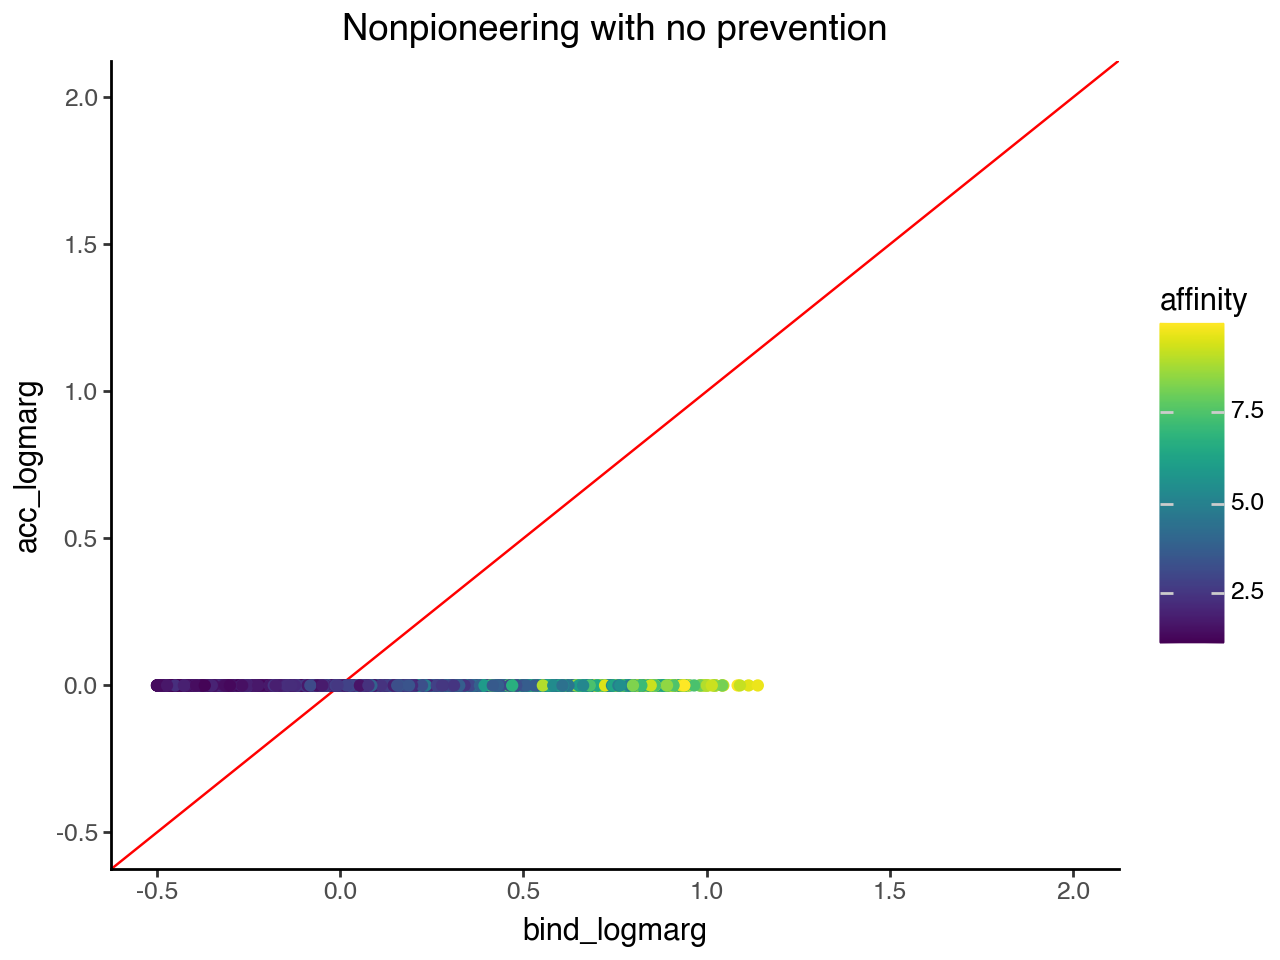

In [8]:
nonpioneer_plot = (ggplot(data = outcome_df, mapping = aes(x = 'bind_logmarg', y = 'acc_logmarg', color = 'affinity'))+
    geom_abline(intercept = 0, slope = 1, color = 'red')+
    geom_point()+
    scale_x_continuous(limits = (-.5,2))+
    scale_y_continuous(limits = (-.5,2))+
    ggtitle('Nonpioneering with no prevention') + 
    theme_classic())
nonpioneer_plot.save(f'{figure_filepath}/nonpioneering_bind_vs_acc.png', dpi = 300)
nonpioneer_plot.save(f'{figure_filepath}/nonpioneering_bind_vs_acc.pdf')
print(nonpioneer_plot)

## Simple pioneering

In [9]:
trial_n = 10000
outcome_df = generate_L_1TF_2c(gA_list=[0.1, 0.9], 
                               a1A_list=[5,5],
                               a2Af_list=[1,1], 
                               # betanA_list = [1,1],
                               # betamA_list = [1,1],
                               trials = trial_n)
outcome_df['acc_Pmarg'] = outcome_df['acc_A'] - outcome_df['acc_null']
outcome_df['bind_Pmarg'] = outcome_df['bind_A'] - outcome_df['bind_null']
outcome_df['acc_logmarg'] = np.log(outcome_df['acc_A']) - np.log(outcome_df['acc_null'])
outcome_df['bind_logmarg'] = np.log(outcome_df['bind_A']) - np.log(outcome_df['bind_null'])
outcome_df['affinity'] = 1/outcome_df['gAvals']

outcome_df.to_csv('kinetics_4state_pioneering.tsv.gz', sep = '\t', index = False)
outcome_df.head()


negativepsets 0


gAvals  a1Avals  a2Avals  acc_null     acc_A  bind_null    bind_A  \
0  0.120741      5.0      1.0  0.090117  0.134868   0.284809  0.584307   
1  0.365584      5.0      1.0  0.167401  0.173811   0.361860  0.398961   
2  0.116602      5.0      1.0  0.129477  0.200414   0.262795  0.603377   
3  0.115580      5.0      1.0  0.047264  0.077510   0.239837  0.575101   
4  0.290033      5.0      1.0  0.125938  0.141485   0.243387  0.321753   

   acc_Pmarg  bind_Pmarg  acc_logmarg  bind_logmarg  affinity  
0   0.044751    0.299498     0.403192      0.718608  8.282192  
1   0.006411    0.037101     0.037579      0.097607  2.735351  
2   0.070937    0.340581     0.436881      0.831166  8.576215  
3   0.030247    0.335264     0.494667      0.874585  8.652001  
4   0.015547    0.078367     0.116404      0.279134  3.447884

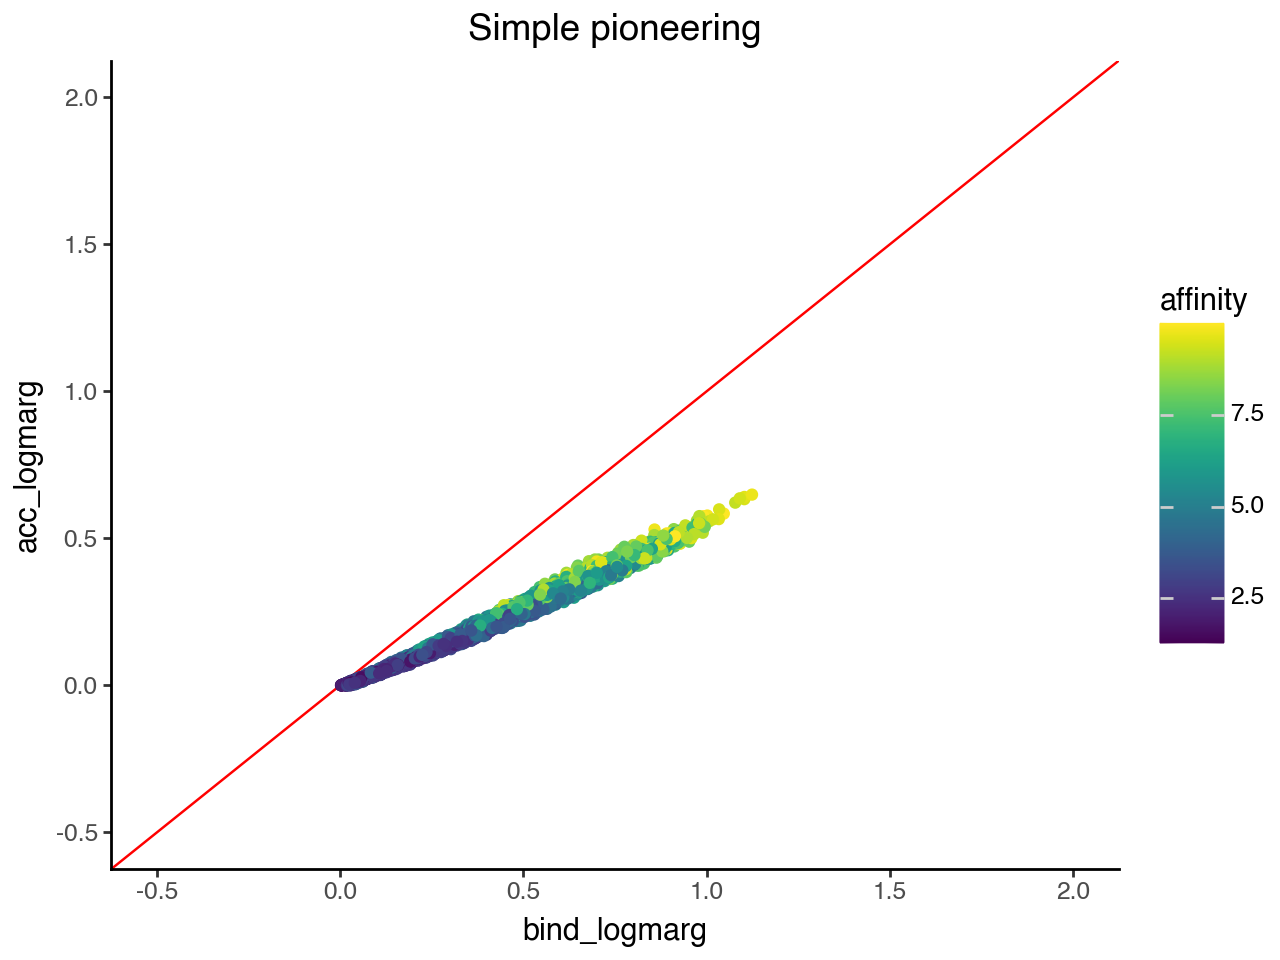

In [10]:
pioneer_plot =(ggplot(data = outcome_df, mapping = aes(x = 'bind_logmarg', y = 'acc_logmarg', color = 'affinity'))+
    geom_abline(intercept = 0, slope = 1, color = 'red')+
    geom_point()+
    scale_x_continuous(limits = (-.5,2))+
    scale_y_continuous(limits = (-.5,2))+
    ggtitle('Simple pioneering') + 
    theme_classic())
#pioneer_plot.save(f'{figure_filepath}/simplepioneering_bind_vs_acc.png', dpi = 300)
#pioneer_plot.save(f'{figure_filepath}/simplepioneering_bind_vs_acc.pdf')
pioneer_plot.show()

# Simple pioneering + c=1/beta

In [10]:
trial_n = 10000
outcome_df = generate_L_1TF_2c_c1overbeta(gA_list=[0.1, 0.9], 
                               a1A_list=[5,5],
                               a2Af_list=[1,1],
                               betanA_list = [2,4],  #RMC - factor increase in off-rate due to nucleosome, non-specific DNAMelanie-likelihood to bind to the nucleosome
                               betamA_list = [5,10],
                               trials = trial_n)
outcome_df['acc_Pmarg'] = outcome_df['acc_A'] - outcome_df['acc_null']
outcome_df['bind_Pmarg'] = outcome_df['bind_A'] - outcome_df['bind_null']
outcome_df['acc_logmarg'] = np.log(outcome_df['acc_A']) - np.log(outcome_df['acc_null'])
outcome_df['bind_logmarg'] = np.log(outcome_df['bind_A']) - np.log(outcome_df['bind_null'])
outcome_df['affinity'] = 1/outcome_df['gAvals']

outcome_df.to_csv('kinetics_4state_pioneering_c1overbeta.tsv.gz', sep = '\t', index = False)
outcome_df.head()


negativepsets 0


gAvals  a1Avals   a2Avals  acc_null     acc_A  bind_null    bind_A  \
0  0.672151      5.0  3.089766  0.181371  0.233800   0.312616  0.305221   
1  0.676260      5.0  2.604665  0.151173  0.201109   0.328058  0.312206   
2  0.120741      5.0  2.870645  0.157043  0.462330   0.315178  0.715060   
3  0.666518      5.0  3.021655  0.181447  0.232946   0.315703  0.278950   
4  0.537786      5.0  3.429632  0.254230  0.351499   0.322704  0.384043   

   acc_Pmarg  bind_Pmarg  acc_logmarg  bind_logmarg  affinity  
0   0.052429   -0.007396     0.253921     -0.023942  1.487760  
1   0.049936   -0.015852     0.285420     -0.049528  1.478722  
2   0.305286    0.399882     1.079756      0.819230  8.282192  
3   0.051499   -0.036754     0.249842     -0.123772  1.500334  
4   0.097269    0.061339     0.323967      0.174019  1.859476

/Users/rosamartinezcorral/miniconda3/envs/torchEnv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 114 rows containing missing values.


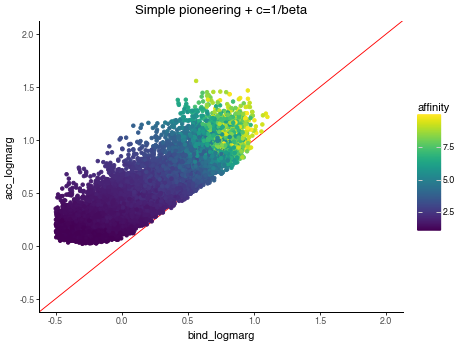

In [11]:
pioneer_plot =(ggplot(data = outcome_df, mapping = aes(x = 'bind_logmarg', y = 'acc_logmarg', color = 'affinity'))+
    geom_abline(intercept = 0, slope = 1, color = 'red')+
    geom_point()+
    scale_x_continuous(limits = (-.5,2))+
    scale_y_continuous(limits = (-.5,2))+
    ggtitle('Simple pioneering + c=1/beta') + 
    theme_classic())
#pioneer_plot.save(f'{figure_filepath}/simplepioneering_bind_vs_acc.png', dpi = 300)
#pioneer_plot.save(f'{figure_filepath}/simplepioneering_bind_vs_acc.pdf')
pioneer_plot.show()

In [9]:
#no opening. Equilibrium model.
trial_n = 10000
outcome_df = generate_L_1TF_2c_c1overbeta(gA_list=[0.1, 0.9], 
                               a1A_list=[1,1],
                               a2Af_list=[1,1],
                               betanA_list = [2,4],  #RMC - factor increase in off-rate due to nucleosome, non-specific DNAMelanie-likelihood to bind to the nucleosome
                               betamA_list = [5,10],
                               trials = trial_n)
outcome_df['acc_Pmarg'] = outcome_df['acc_A'] - outcome_df['acc_null']
outcome_df['bind_Pmarg'] = outcome_df['bind_A'] - outcome_df['bind_null']
outcome_df['acc_logmarg'] = np.log(outcome_df['acc_A']) - np.log(outcome_df['acc_null'])
outcome_df['bind_logmarg'] = np.log(outcome_df['bind_A']) - np.log(outcome_df['bind_null'])
outcome_df['affinity'] = 1/outcome_df['gAvals']

outcome_df.to_csv('kinetics_4state_c1overbeta.tsv.gz', sep = '\t', index = False)
outcome_df.head()


negativepsets 0


gAvals  a1Avals   a2Avals  acc_null     acc_A  bind_null    bind_A  \
0  0.672151      1.0  3.089766  0.082351  0.108903   0.265552  0.219175   
1  0.676260      1.0  2.604665  0.064276  0.085642   0.291725  0.238555   
2  0.120741      1.0  2.870645  0.068065  0.174230   0.274803  0.600024   
3  0.666518      1.0  3.021655  0.082163  0.113922   0.269305  0.189600   
4  0.537786      1.0  3.429632  0.130627  0.185406   0.261577  0.266943   

   acc_Pmarg  bind_Pmarg  acc_logmarg  bind_logmarg  affinity  
0   0.026552   -0.046377     0.279468     -0.191941  1.487760  
1   0.021365   -0.053170     0.286982     -0.201213  1.478722  
2   0.106165    0.325221     0.939912      0.780916  8.282192  
3   0.031759   -0.079705     0.326809     -0.350928  1.500334  
4   0.054778    0.005366     0.350198      0.020307  1.859476

/Users/rosamartinezcorral/miniconda3/envs/torchEnv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 822 rows containing missing values.


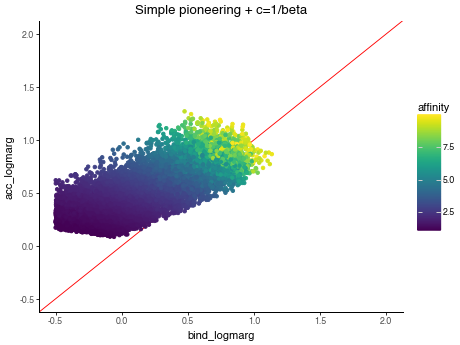

In [10]:
pioneer_plot =(ggplot(data = outcome_df, mapping = aes(x = 'bind_logmarg', y = 'acc_logmarg', color = 'affinity'))+
    geom_abline(intercept = 0, slope = 1, color = 'red')+
    geom_point()+
    scale_x_continuous(limits = (-.5,2))+
    scale_y_continuous(limits = (-.5,2))+
    ggtitle('Simple pioneering + c=1/beta') + 
    theme_classic())
#pioneer_plot.save(f'{figure_filepath}/simplepioneering_bind_vs_acc.png', dpi = 300)
#pioneer_plot.save(f'{figure_filepath}/simplepioneering_bind_vs_acc.pdf')
pioneer_plot.show()

# Simulate 2TF, 8-state pioneering

Here, we will simulate the 8-state conformation of 2TFs being in open/closed confifurations with/without motifs.

## Helper functions

In [7]:
def generate_L_2TFs_2c(gA_list, gB_list, #affinities of each TF
                       a1A_list, a1B_list, #opening effects of each TF
                       a2Af_list, a2Bf_list, #closing effects of each TF
                       betanA_list = [2,4],  betanB_list = [2,4], #increase in off-rate due to nucleosome, non-specific DNA
                       betamA_list = [5, 10],  betamB_list = [5, 10], #increase in off-rate due to nucleosome, DNA with motif
                       kopen0=0.05, konA = .1, konB = .1, KA = 1, 
                       d_list=[0.001,0.01],
                       h1=1, h0=1, #binding interactions BETWEEN two TFs
                       trials = 10000): #extra parameters
    """
    A given TF increases the opening rate by an amount i_x, and when both are bound, the amounts multiplies, 8-state model
    Consider only parameter sets where both A and B individually increase accessibility
    Assume that the effect of the TF does not change when it is bound to a motif with respect to when it is bound non-specifically 
    """      
    yvals=[]; xvals=[]; gAvals=[]; gBvals=[]; a1Avals=[]; a1Bvals=[]; a2Avals=[]; a2Bvals=[]; 
    parsets=[]; A0vals=[]; AAvals=[]; ABvals=[]; AABvals=[]
    # bA_0vals = []; bA_Avals = []; bA_Bvals = []; bA_ABvals.append(b_AB);
    # bB_0vals.append(bB_0);bB_Avals.append(bB_A);bB_Bvals.append(bB_B);bB_ABvals.append(bB_AB);    

    negativepsets=0
    for i in range(trials):
        np.random.seed(i)
        # kopen0=0.05 #10**np.random.uniform(-4,-2) #assume opening happens in the minutes to hours range
        d=np.random.uniform(d_list[0],d_list[1]) #if dmax is too large, then less cooperativity because it is already open
        kclose0=kopen0/d #np.random.uniform(0.001,0.01)
    
        # konA=konB=0.1
        # KA=1 #np.random.uniform(1,5)
        koff1nA=konA/KA
        koff1nB=konB/KA
        
        gA=np.random.uniform(gA_list[0],gA_list[1]) 
        gB=np.random.uniform(gB_list[0],gB_list[1])
        
        a1A=np.random.uniform(a1A_list[0],a1A_list[1]) 
        a1Afactorincrease=1 #np.random.uniform(1,3) #small values here generate more cooperativity, 
        a1nA=a1A
        a1mA=a1nA*a1Afactorincrease
    
        a1B=np.random.uniform(a1B_list[0],a1B_list[1]) 
        a1Bfactorincrease=1 #np.random.uniform(1,2)
        a1nB=a1B
        a1mB=a1nB*a1Bfactorincrease
    
        betanA=np.random.uniform(betanA_list[0],betanA_list[1]) #np.random.normal(5,0.1)
        betamA=np.random.uniform(betamA_list[0],betamA_list[1])
    
        betanB=np.random.uniform(betanB_list[0],betanB_list[1]) #np.random.normal(5,0.1)
        betamB=np.random.uniform(betamB_list[0],betamB_list[1])

    
        #assume some effect on the closing
        a2mAf=np.random.uniform(a2Af_list[0], a2Af_list[1]) #a2nAf*np.random.uniform(1,2) #min(np.random.normal(0.8,0.15),1) 
        a2nAf = a2mAf
        
        a2mBf=np.random.uniform(a2Bf_list[0], a2Bf_list[1]) #a2nBf*np.random.uniform(1,2) #np.random.uniform(1,2) #min(np.random.normal(0.8,0.15),1) 
        a2nBf = a2mBf
        
        a2nA=1/a2nAf; a2mA=1/a2mAf; a2nB=1/a2nBf; a2mB=1/a2mBf
        assert a2nA==a2mA
        assert a2nB==a2mB
            
        a1nAB=a1nA*a1nB; a1mAmB=a1mA*a1mB; a1mAnB=a1mA*a1nB; a1nAmB=a1nA*a1mB
        a2nAB=1/(a2nAf*a2nBf); a2mAnB=1/(a2mAf*a2nBf); a2nAmB=1/(a2nAf*a2mBf); a2mAmB=1/(a2mAf*a2mBf)
    
        
        parset=[konA,konB,koff1nA,koff1nB,gA,gB,betanA, betanB, betamA, betamB,h0,h1, kopen0,kclose0, a1nA, a1nB, a1nAB, a1mA, a1mB, a1mAnB, a1nAmB, a1mAmB, a2nA, a2nB, a2nAB, a2mA, a2mB, a2mAnB, a2nAmB, a2mAmB]
        parsetar=np.array(parset)
        if not np.all(parsetar>0):
            negativepsets+=1
        else:
            A_0, A_A, A_B, A_AB =model_2TFs_reference_nakednomotif(parset, idx_openconc=4, Lfunc=L_2TFs_2c)
            # A_0, A_A, A_B, A_AB, b_0, b_A, b_B, b_AB,bB_0, bB_A, bB_B, bB_AB =model_2TFs_reference_nakednomotif(parset, idx_openconc=4, Lfunc=L_2TFs_2c)
            if A_A>A_0 and A_B>A_0:
                yvals.append(A_AB-A_0);xvals.append(A_A-A_0+A_B-A_0)
                gAvals.append(gA);gBvals.append(gB)
                parsets.append(",".join(list(map(str,parset))));
                A0vals.append(A_0);AAvals.append(A_A);ABvals.append(A_B);AABvals.append(A_AB);
                a1Avals.append(a1nA);a1Bvals.append(a1nB);a2Avals.append(a2nAf);a2Bvals.append(a2nBf);
                # bA_0vals.append(b_0);bA_Avals.append(b_A);bA_Bvals.append(b_B);bA_ABvals.append(b_AB);
                # bB_0vals.append(bB_0);bB_Avals.append(bB_A);bB_Bvals.append(bB_B);bB_ABvals.append(bB_AB);
                
    #print("negativepsets",negativepsets)
    yvalsar=np.array(yvals)
    xvalsar=np.array(xvals)
    
    coopvals=np.log(yvalsar/xvalsar)
    coopvals=np.log(yvalsar/xvalsar)
    
    #Append to pd.df
    outcome_df = pd.DataFrame([yvalsar, xvalsar, gAvals, gBvals, a1Avals, a1Bvals, a2Avals, a2Bvals, coopvals,
                              A0vals, AAvals, ABvals, AABvals, parsets]).transpose()
    outcome_df.columns = ['acc_joint', 'acc_marg', 'gAvals', 'gBvals', 'a1Avals', 'a1Bvals', 'a2Avals', 'a2Bvals', 'acc_coopvals',
                         'acc_null','acc_A','acc_B','acc_AB', 'parset']
    return outcome_df

In [10]:
def generate_input_output_2TFs_2c_Aonlychange_ns(gA_list, gB_list, #affinities of each TF
                       a1A_list, a1B_list, #opening effects of each TF
                       a2Af_list, a2Bf_list, #closing effects of each TF
                       betanA_list = [2,4],  betanB_list = [2,4], #increase in off-rate due to nucleosome, non-specific DNA
                       betamA_list = [5, 10],  betamB_list = [5, 10], #increase in off-rate due to nucleosome, DNA with motif
                       kopen0=0.05, konrange=None,koff=1, 
                       d_list=[0.001,0.01],
                       h1=1, h0=1, #binding interactions BETWEEN two TFs
                       trials = 10000,
                       sameclosingeffect=True): #extra parameters
    """
    A given TF increases the opening rate by an amount i_x, and when both are bound, the amounts multiplies, 8-state model
    Consider only parameter sets where both A and B individually increase accessibility
    Assume that the effect of the TF does not change when it is bound to a motif with respect to when it is bound non-specifically (sameclosingeffect=True), or only a1 does not change.
    """      
    #yvals=[]; xvals=[]; gAvals=[]; gBvals=[]; a1Avals=[]; a1Bvals=[]; a2Avals=[]; a2Bvals=[]; 
    parsets=[]; A0vals=[]; AAvals=[]; ABvals=[]; AABvals=[]
    AAalonevals=[];ABalonevals=[];
    cooperativities=[];
    # bA_0vals = []; bA_Avals = []; bA_Bvals = []; bA_ABvals.append(b_AB);
    # bB_0vals.append(bB_0);bB_Avals.append(bB_A);bB_Bvals.append(bB_B);bB_ABvals.append(bB_AB);    

    negativepsets=0
    
    for i in range(trials):
        np.random.seed(i)
        # kopen0=0.05 #10**np.random.uniform(-4,-2) #assume opening happens in the minutes to hours range
        d=np.random.uniform(d_list[0],d_list[1]) #if dmax is too large, then less cooperativity because it is already open
        kclose0=kopen0/d #np.random.uniform(0.001,0.01)
    
        konA=konB=0.1
        # KA=1 #np.random.uniform(1,5)
        koff1nA=koff
        koff1nB=koff
        
        gA=np.random.uniform(gA_list[0],gA_list[1]) 
        gB=np.random.uniform(gB_list[0],gB_list[1])
        
        a1A=np.random.uniform(a1A_list[0],a1A_list[1]) 
        a1Afactorincrease=1 #np.random.uniform(1,3) #small values here generate more cooperativity, 
        a1nA=a1A
        a1mA=a1nA*a1Afactorincrease
    
        a1B=np.random.uniform(a1B_list[0],a1B_list[1]) 
        a1Bfactorincrease=1 #np.random.uniform(1,2)
        a1nB=a1B
        a1mB=a1nB*a1Bfactorincrease
    
        betanA=np.random.uniform(betanA_list[0],betanA_list[1]) #np.random.normal(5,0.1)
        betamA=np.random.uniform(betamA_list[0],betamA_list[1])
    
        betanB=np.random.uniform(betanB_list[0],betanB_list[1]) #np.random.normal(5,0.1)
        betamB=np.random.uniform(betamB_list[0],betamB_list[1])

    
        #assume some effect on the closing
        a2mAf=np.random.uniform(a2Af_list[0], a2Af_list[1]) #a2nAf*np.random.uniform(1,2) #min(np.random.normal(0.8,0.15),1) 
        if sameclosingeffect:
            a2nAf = a2mAf
        else:
            a2nAf=1
        
        a2mBf=np.random.uniform(a2Bf_list[0], a2Bf_list[1]) #a2nBf*np.random.uniform(1,2) #np.random.uniform(1,2) #min(np.random.normal(0.8,0.15),1) 
        if sameclosingeffect:
            a2nBf = a2mBf
        else:
            a2nBf=1
        
        a2nA=1/a2nAf; a2mA=1/a2mAf; a2nB=1/a2nBf; a2mB=1/a2mBf
        #assert a2nA==a2mA
        #assert a2nB==a2mB
            
        a1nAB=a1nA*a1nB; a1mAmB=a1mA*a1mB; a1mAnB=a1mA*a1nB; a1nAmB=a1nA*a1mB
        a2nAB=1/(a2nAf*a2nBf); a2mAnB=1/(a2mAf*a2nBf); a2nAmB=1/(a2nAf*a2mBf); a2mAmB=1/(a2mAf*a2mBf)
    
        parslist=[koff1nA,koff1nB,gA,gB,betanA, betanB, betamA, betamB,h0,h1, kopen0,kclose0, a1nA, a1nB, a1nAB, a1mA, a1mB, a1mAnB, a1nAmB, a1mAmB, a2nA, a2nB, a2nAB, a2mA, a2mB, a2mAnB, a2nAmB, a2mAmB]

        A0vals_=[]; AAvals_=[]; ABvals_=[]; AABvals_=[]
        AAalonevals_=[];ABalonevals_=[];
        cooperativity_=[]
        for kon in konrange:
            
            parset=[kon,konB]+parslist
                
            parsetar=np.array(parset)
            if not np.all(parsetar>=0):
                negativepsets+=1
                print("negativepsets")

            else:
                parsetA=np.array([kon,koff1nA,gA,betanA,betamA, kopen0,kclose0, a1nA,a2nA, a1mA, a2mA])
                parsetB=np.array([konB,koff1nB,gB,betanB,betamB,kopen0,kclose0,a1nB,a2nB,a1mB,a2mB])
                A0_Aalone,A_Aalone=model_1TF_reference_nakednomotif(parsetA,idx_openconc=2,Lfunc=L_1TF_2c)
                A0_Balone,A_Balone=model_1TF_reference_nakednomotif(parsetB,idx_openconc=2,Lfunc=L_1TF_2c)
                A_0, A_A, A_B, A_AB =model_2TFs_reference_nakednomotif(parsetar, idx_openconc=4, Lfunc=L_2TFs_2c)
                # A_0, A_A, A_B, A_AB, b_0, b_A, b_B, b_AB,bB_0, bB_A, bB_B, bB_AB =model_2TFs_reference_nakednomotif(parset, idx_openconc=4, Lfunc=L_2TFs_2c)
                A0vals_.append(A_0);AAvals_.append(A_A);ABvals_.append(A_B);AABvals_.append(A_AB);
                AAalonevals_.append(A_Aalone);
                ABalonevals_.append(A_Balone)
                if A_AB-A_0<1e-10:
                    cooperativity_.append(-1000)
                else:
                    cooperativity_.append(np.log((A_AB-A_0)/(1e-10+A_A-A_0+A_B-A_0)))
        A0vals.append(",".join(list(map(str,A0vals_))))
        AAvals.append(",".join(list(map(str,AAvals_))))
        ABvals.append(",".join(list(map(str,ABvals_))))
        AABvals.append(",".join(list(map(str,AABvals_))))
        AAalonevals.append(",".join(list(map(str,AAalonevals_))))
        ABalonevals.append(",".join(list(map(str,ABalonevals_))))
        cooperativities.append(",".join(list(map(str,cooperativity_))))
        parsets.append(",".join(list(map(str,parset))));
                
                    
        
    outcome_df = pd.DataFrame([cooperativities,A0vals, AAvals, ABvals, AABvals,AAalonevals,ABalonevals, parsets]).transpose()
    outcome_df.columns = ['acc_coopvals','acc_null','acc_A','acc_B','acc_AB', 'acc_Aonly','acc_Bonly','parset']
    return outcome_df
        

In [11]:
def generate_L_2TFs_2c_c1overbeta(gA_list, gB_list, #affinities of each TF
                       a1A_list, a1B_list, #opening effects of each TF
                       betanA_list = [2,4],  betanB_list = [2,4], #increase in off-rate due to nucleosome, non-specific DNA
                       betamA_list = [5, 10],  betamB_list = [5, 10], #increase in off-rate due to nucleosome, DNA with motif
                       kopen0=0.05, konA = .1, konB = .1, KA = 1, 
                       d_list=[0.001,0.01],
                       h1=1, h0=1, #binding interactions BETWEEN two TFs
                       trials = 10000): #extra parameters
    """
    A given TF increases the opening rate by an amount i_x, and when both are bound, the amounts multiplies, 8-state model
    Consider only parameter sets where both A and B individually increase accessibility
    Assume that the effect of the TF does not change when it is bound to a motif with respect to when it is bound non-specifically 
    """      
    yvals=[]; xvals=[]; gAvals=[]; gBvals=[]; a1Avals=[]; a1Bvals=[]; a2Avals=[]; a2Bvals=[]; 
    parsets=[]; A0vals=[]; AAvals=[]; ABvals=[]; AABvals=[]
    # bA_0vals = []; bA_Avals = []; bA_Bvals = []; bA_ABvals.append(b_AB);
    # bB_0vals.append(bB_0);bB_Avals.append(bB_A);bB_Bvals.append(bB_B);bB_ABvals.append(bB_AB);    

    negativepsets=0
    for i in range(trials):
        np.random.seed(i)
        # kopen0=0.05 #10**np.random.uniform(-4,-2) #assume opening happens in the minutes to hours range
        d=np.random.uniform(d_list[0],d_list[1]) #if dmax is too large, then less cooperativity because it is already open
        kclose0=kopen0/d #np.random.uniform(0.001,0.01)
    
        # konA=konB=0.1
        # KA=1 #np.random.uniform(1,5)
        koff1nA=konA/KA
        koff1nB=konB/KA
        
        gA=np.random.uniform(gA_list[0],gA_list[1]) 
        gB=np.random.uniform(gB_list[0],gB_list[1])
        
        a1A=np.random.uniform(a1A_list[0],a1A_list[1]) 
        a1Afactorincrease=1 #np.random.uniform(1,3) #small values here generate more cooperativity, 
        a1nA=a1A
        a1mA=a1nA*a1Afactorincrease
    
        a1B=np.random.uniform(a1B_list[0],a1B_list[1]) 
        a1Bfactorincrease=1 #np.random.uniform(1,2)
        a1nB=a1B
        a1mB=a1nB*a1Bfactorincrease
    
        betanA=np.random.uniform(betanA_list[0],betanA_list[1]) #np.random.normal(5,0.1)
        betamA=np.random.uniform(betamA_list[0],betamA_list[1])
    
        betanB=np.random.uniform(betanB_list[0],betanB_list[1]) #np.random.normal(5,0.1)
        betamB=np.random.uniform(betamB_list[0],betamB_list[1])

    
        #assume some effect on the closing
        #a2mAf=np.random.uniform(a2Af_list[0], a2Af_list[1]) #a2nAf*np.random.uniform(1,2) #min(np.random.normal(0.8,0.15),1) 
        #a2nAf = a2mAf
        
        #a2mBf=np.random.uniform(a2Bf_list[0], a2Bf_list[1]) #a2nBf*np.random.uniform(1,2) #np.random.uniform(1,2) #min(np.random.normal(0.8,0.15),1) 
        #a2nBf = a2mBf
        
        a2nAf=betanA
        a2mAf=betamA
        a2nBf=betanB
        a2mBf=betamB
        
        a2nA=1/a2nAf; a2mA=1/a2mAf; a2nB=1/a2nBf; a2mB=1/a2mBf
        #assert a2nA==a2mA
        #assert a2nB==a2mB
            
        a1nAB=a1nA*a1nB; a1mAmB=a1mA*a1mB; a1mAnB=a1mA*a1nB; a1nAmB=a1nA*a1mB
        a2nAB=1/(a2nAf*a2nBf); a2mAnB=1/(a2mAf*a2nBf); a2nAmB=1/(a2nAf*a2mBf); a2mAmB=1/(a2mAf*a2mBf)
    
        
        parset=[konA,konB,koff1nA,koff1nB,gA,gB,betanA, betanB, betamA, betamB,h0,h1, kopen0,kclose0, a1nA, a1nB, a1nAB, a1mA, a1mB, a1mAnB, a1nAmB, a1mAmB, a2nA, a2nB, a2nAB, a2mA, a2mB, a2mAnB, a2nAmB, a2mAmB]
        parsetar=np.array(parset)
        if not np.all(parsetar>0):
            negativepsets+=1
        else:
            A_0, A_A, A_B, A_AB =model_2TFs_reference_nakednomotif(parset, idx_openconc=4, Lfunc=L_2TFs_2c)
            # A_0, A_A, A_B, A_AB, b_0, b_A, b_B, b_AB,bB_0, bB_A, bB_B, bB_AB =model_2TFs_reference_nakednomotif(parset, idx_openconc=4, Lfunc=L_2TFs_2c)
            if A_A>A_0 and A_B>A_0:
                yvals.append(A_AB-A_0);xvals.append(A_A-A_0+A_B-A_0)
                gAvals.append(gA);gBvals.append(gB)
                parsets.append(",".join(list(map(str,parset))));
                A0vals.append(A_0);AAvals.append(A_A);ABvals.append(A_B);AABvals.append(A_AB);
                a1Avals.append(a1nA);a1Bvals.append(a1nB);a2Avals.append(a2nAf);a2Bvals.append(a2nBf);
                # bA_0vals.append(b_0);bA_Avals.append(b_A);bA_Bvals.append(b_B);bA_ABvals.append(b_AB);
                # bB_0vals.append(bB_0);bB_Avals.append(bB_A);bB_Bvals.append(bB_B);bB_ABvals.append(bB_AB);
                
    #print("negativepsets",negativepsets)
    yvalsar=np.array(yvals)
    xvalsar=np.array(xvals)
    
    coopvals=np.log(yvalsar/xvalsar)
    coopvals=np.log(yvalsar/xvalsar)
    
    #Append to pd.df
    outcome_df = pd.DataFrame([yvalsar, xvalsar, gAvals, gBvals, a1Avals, a1Bvals, a2Avals, a2Bvals, coopvals,
                              A0vals, AAvals, ABvals, AABvals, parsets]).transpose()
    outcome_df.columns = ['acc_joint', 'acc_marg', 'gAvals', 'gBvals', 'a1Avals', 'a1Bvals', 'a2Avals', 'a2Bvals', 'acc_coopvals',
                         'acc_null','acc_A','acc_B','acc_AB', 'parset']
    return outcome_df

## Simulate S/S systematically

In [14]:
trial_n = 100000

# outcomes_df = pd.DataFrame()
# for p_n, p in enumerate([[1,1], [1,10]]): #for pioneering possibilities
#     for b_n, b in enumerate([[1,1]]): #for binding possibilities
#         # print(p_n, b_n)
#         outcome_df = generate_L_2TFs_2c(gA_list=[0.1, 0.9], gB_list=[0.1,0.9],
#                                         d_list=[0.001,0.01],
#                                         a1A_list=p, a1B_list=p, 
#                                         a2Af_list=b, a2Bf_list=b,
#                                         trials = trial_n)
#         outcome_df['scenario_pioneer'] = 'pioneer-' + str(p_n)
#         outcome_df['scenario_preventer'] = 'preventer-' + str(b_n)
#         outcomes_df = pd.concat([outcomes_df, outcome_df])

In [15]:
# outcomes_df.head()

Visualize.

In [33]:
# plotnine.options.figure_size = (5, 8)
# (ggplot(data = outcomes_df, mapping = aes(x = 'acc_marg', y = 'acc_joint'))+
#     geom_abline(intercept = 0, slope = 1, color = 'red')+
#     geom_point()+ 
#     scale_x_continuous(limits = (0, .5))+
#     scale_y_continuous(limits = (0, .5))+    
#     facet_grid('scenario_pioneer ~ scenario_preventer') + 
#     theme_classic())

## Classify different motif scenarios

In [34]:
# #classify affinity features
# aff_bins = [.1, .3, .5, .9]
# aff_labels = ['high', 'mid', 'low']

# outcomes_df['affA_trait'] = pd.cut(outcomes_df['gAvals'], aff_bins, labels = aff_labels, right = True)
# outcomes_df['affB_trait'] = pd.cut(outcomes_df['gBvals'], aff_bins, labels = aff_labels, right = True)

# #classify pioneering features
# pion_bins = [0, 1, 2, 6, 10]
# pion_labels = ['non', 'weak', 'mid', 'strong']
# outcomes_df['pionA_trait'] = pd.cut(outcomes_df['a1Avals'], pion_bins, labels = pion_labels, right = True)
# outcomes_df['pionB_trait'] = pd.cut(outcomes_df['a1Bvals'], pion_bins, labels = pion_labels, right = True)

# #classify preventing features
# prev_bins = [0, 1, 2, 6, 10]
# prev_labels = ['non', 'weak', 'mid', 'strong']
# outcomes_df['prevA_trait'] = pd.cut(outcomes_df['a2Avals'], prev_bins, labels = prev_labels, right = True)
# outcomes_df['prevB_trait'] = pd.cut(outcomes_df['a2Bvals'], prev_bins, labels = prev_labels, right = True)

Annotate groups of interest.

In [35]:
# outcomes_df['pion_vs_prevent_vs_aff'] = 'aff:' +  outcomes_df['affA_trait'].astype(str) + '/' + \
#     outcomes_df['affB_trait'].astype(str) + ', pion: ' + outcomes_df['pionA_trait'].astype(str) + '/' + \
#     outcomes_df['pionB_trait'].astype(str) + ', prev: ' + outcomes_df['prevA_trait'].astype(str) + '/' + \
#     outcomes_df['prevB_trait'].astype(str)

In [36]:
# outcomes_df.pion_vs_prevent_vs_aff.value_counts()
# outcomes_df[outcomes_df.pion_vs_prevent_vs_aff.str.contains('low/low')].pion_vs_prevent_vs_aff.value_counts()
# outcomes_df[outcomes_df.pion_vs_prevent_vs_aff.str.contains('strong/strong')].pion_vs_prevent_vs_aff.value_counts()

In [37]:
# outcomes_df.to_csv('tsv/insilico/kinetics_8state_scenarios.tsv.gz', sep = '\t', index = False)

We will visualize and interpret in R.

## Simulate S/s with typical pioneering

In [41]:
trial_n=50000
outcome_df = generate_L_2TFs_2c(gA_list=[0.05, 0.9], gB_list=[0.05, 0.9],
                                d_list=[0.001,0.05],
                                a1A_list=[1,10], a1B_list=[1,10], 
                                a2Af_list=[1,5], a2Bf_list=[1,5],
                                betanA_list = [5,5],  betanB_list = [5,5], #likelihood to bind to the nucleosome,
                                betamA_list = [2, 10],  betamB_list = [2, 10],
                                konA = .1, konB = .1, KA = 0.1,
                                trials = trial_n)
outcome_df.to_csv('kinetics_8state_scenarios_SvsS.tsv.gz', sep = '\t', index = False)

In [42]:
for column in outcome_df.columns[:-1]:
    outcome_df[column]=outcome_df[column].astype(float)

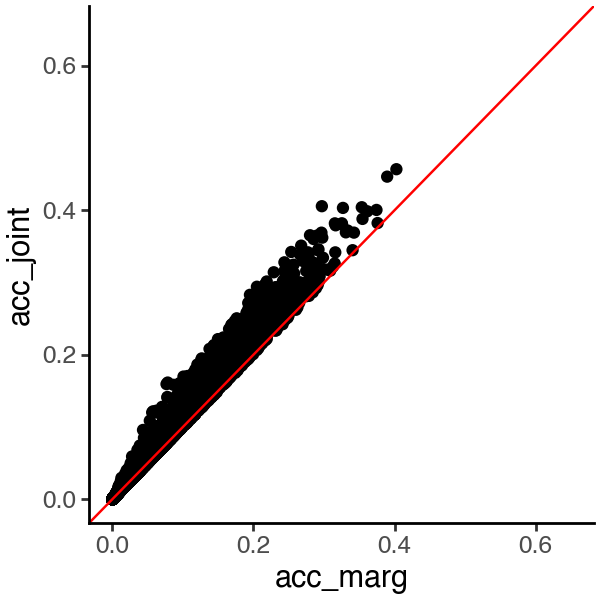

In [43]:
plotnine.options.figure_size = (3, 3)
(ggplot(data = outcome_df, mapping = aes(x = 'acc_marg', y = 'acc_joint'))+
    geom_point()+ 
    geom_abline(intercept = 0, slope = 1, color = 'red')+
     scale_x_continuous(limits = (0, .65))+
     scale_y_continuous(limits = (0, .65))+
    theme_classic())

0


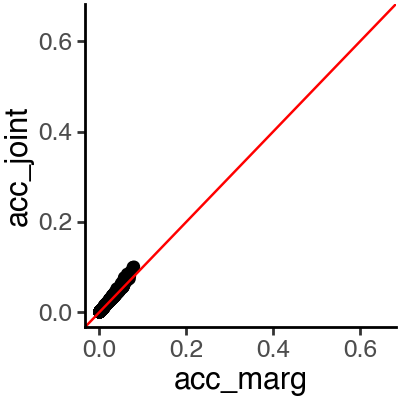

1


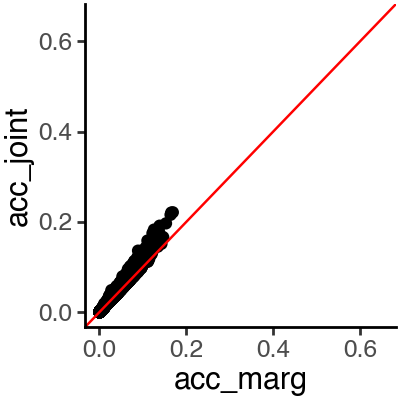

2


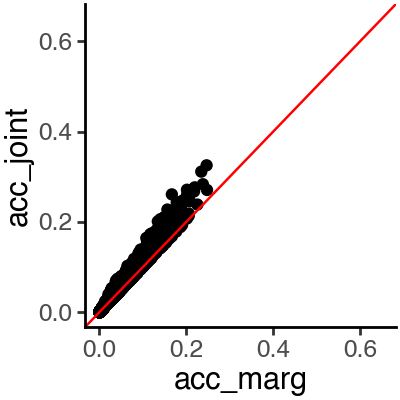

3


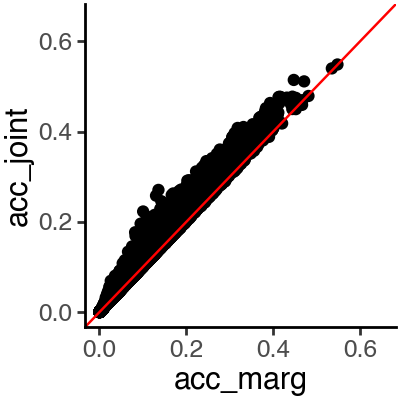

In [43]:
#All changes
for k in range(4):
    if k==0:
        a1A_list=[1,5] #small opening effect
        a1B_list=[1,5]
        a2Af_list=[1,1]
        a2Bf_list=[1,1]
    elif k==1:
        a1A_list=[1,10] #greater opening effect
        a1B_list=[1,10]
        a2Af_list=[1,1]
        a2Bf_list=[1,1]
    if k==2:
        a1A_list=[1,5] #both small opening and closing effect
        a1B_list=[1,5]
        a2Af_list=[1,5]
        a2Bf_list=[1,5]
    elif k==3:
        a1A_list=[1,10] #greater both opening and closing effect
        a1B_list=[1,10]
        a2Af_list=[1,10]
        a2Bf_list=[1,10]
    print(k)
    trial_n=50000
    outcome_df = generate_L_2TFs_2c(gA_list=[0.05, 0.9], gB_list=[0.05, 0.9],
                                    d_list=[0.001,0.05],
                                    a1A_list=a1A_list, a1B_list=a1B_list, 
                                    a2Af_list=a2Af_list, a2Bf_list=a2Bf_list,
                                    betanA_list = [5,5],  betanB_list = [5,5], #decrease in off-rate due to nucleosome, when there is no motif
                                    betamA_list = [2, 10],  betamB_list = [2, 10],
                                    konA=0.1, konB=0.1, KA=0.1, kopen0=0.05,
                                    trials = trial_n)
    #outcome_df.to_csv('kinetics_8state_scenarios_SvsS.tsv.gz', sep = '\t', index = False)
    plotnine.options.figure_size = (2, 2)
    plot=(ggplot(data = outcome_df, mapping = aes(x = 'acc_marg', y = 'acc_joint'))+
        geom_point()+ 
        geom_abline(intercept = 0, slope = 1, color = 'red')+
         scale_x_continuous(limits = (0, .65))+
         scale_y_continuous(limits = (0, .65))+
        theme_classic())
    plot.show()

In [ ]:
# S/S with c=1/beta

In [16]:
trial_n=50000
outcome_df = generate_L_2TFs_2c_c1overbeta(gA_list=[0.05, 0.9], gB_list=[0.05, 0.9],
                                d_list=[0.001,0.05],
                                a1A_list=[1,10], a1B_list=[1,10], 
                                betanA_list = [5,5],  betanB_list = [5,5], #likelihood to bind to the nucleosome,
                                betamA_list = [2, 10],  betamB_list = [2, 10],
                                konA = .1, konB = .1, KA = 0.1,
                                trials = trial_n)
outcome_df.to_csv('kinetics_8state_scenarios_SvsS_c1overbeta.tsv.gz', sep = '\t', index = False)

In [17]:
for column in outcome_df.columns[:-1]:
    outcome_df[column]=outcome_df[column].astype(float)

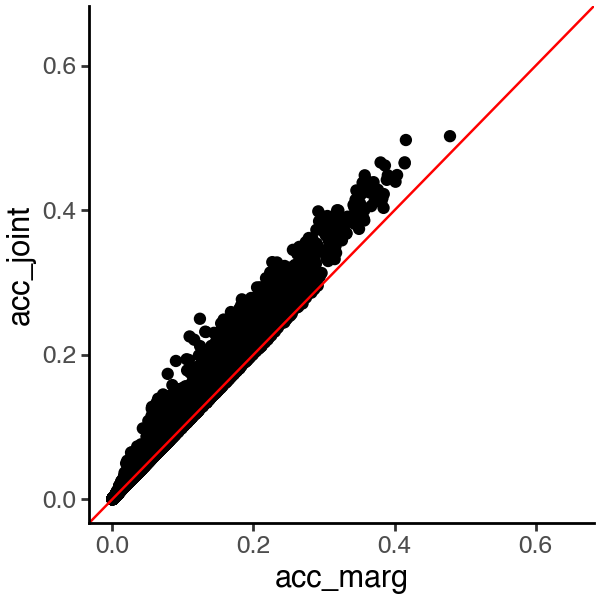

In [18]:
plotnine.options.figure_size = (3, 3)
(ggplot(data = outcome_df, mapping = aes(x = 'acc_marg', y = 'acc_joint'))+
    geom_point()+ 
    geom_abline(intercept = 0, slope = 1, color = 'red')+
     scale_x_continuous(limits = (0, .65))+
     scale_y_continuous(limits = (0, .65))+
    theme_classic())

## Simulate S/OS with stabilized binding

In [89]:
#All changes
trial_n=50000
outcome_df = generate_L_2TFs_2c(gA_list=[0.05, 0.9], gB_list=[0.001,0.5],
                                d_list=[0.001,0.05],
                                a1A_list=[1,10], a1B_list=[1,10], 
                                a2Af_list=[1,5], a2Bf_list=[1,10],
                                betanA_list = [5, 5],  betanB_list = [5, 5], #likelihood to bind to the nucleosome,
                                betamA_list = [2, 10],  betamB_list = [2, 10],
                                konA = .1, konB = .1, KA = .1,
                                trials = trial_n)
outcome_df.to_csv('kinetics_8state_scenarios_SvsOS.tsv.gz', sep = '\t', index = False)

/Users/rosamartinezcorral/miniconda3/envs/torchEnv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 67 rows containing missing values.


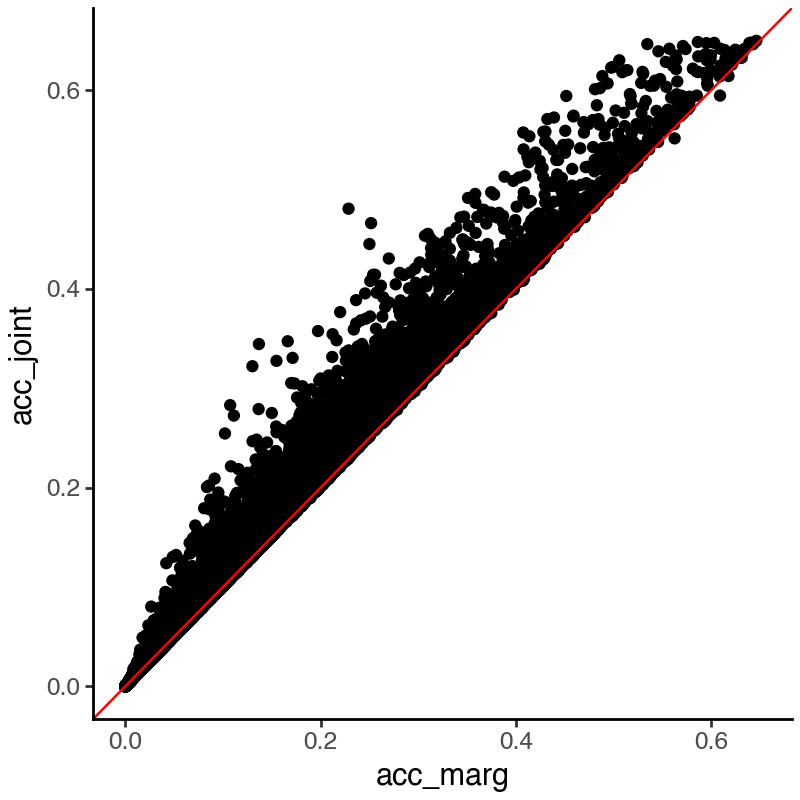

In [19]:
plotnine.options.figure_size = (4, 4)
plot=(ggplot(data = outcome_df, mapping = aes(x = 'acc_marg', y = 'acc_joint'))+
    geom_point()+ 
    geom_abline(intercept = 0, slope = 1, color = 'red')+
     scale_x_continuous(limits = (0, .65))+
     scale_y_continuous(limits = (0, .65))+
    theme_classic())
plot.show()

# S-OS with stabilised binding and c=1/beta

In [19]:
#All changes
trial_n=50000
outcome_df = generate_L_2TFs_2c_c1overbeta(gA_list=[0.05, 0.9], gB_list=[0.001,0.5],
                                d_list=[0.001,0.05],
                                a1A_list=[1,10], a1B_list=[1,10], 
                                betanA_list = [5, 5],  betanB_list = [5, 5], #likelihood to bind to the nucleosome,
                                betamA_list = [2, 10],  betamB_list = [2, 10],
                                konA = .1, konB = .1, KA = .1,
                                trials = trial_n)
outcome_df.to_csv('kinetics_8state_scenarios_SvsOS_c1overbeta.tsv.gz', sep = '\t', index = False)

In [21]:
for column in outcome_df.columns[:-1]:
    outcome_df[column]=outcome_df[column].astype(float)

/Users/rosamartinezcorral/miniconda3/envs/torchEnv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 74 rows containing missing values.


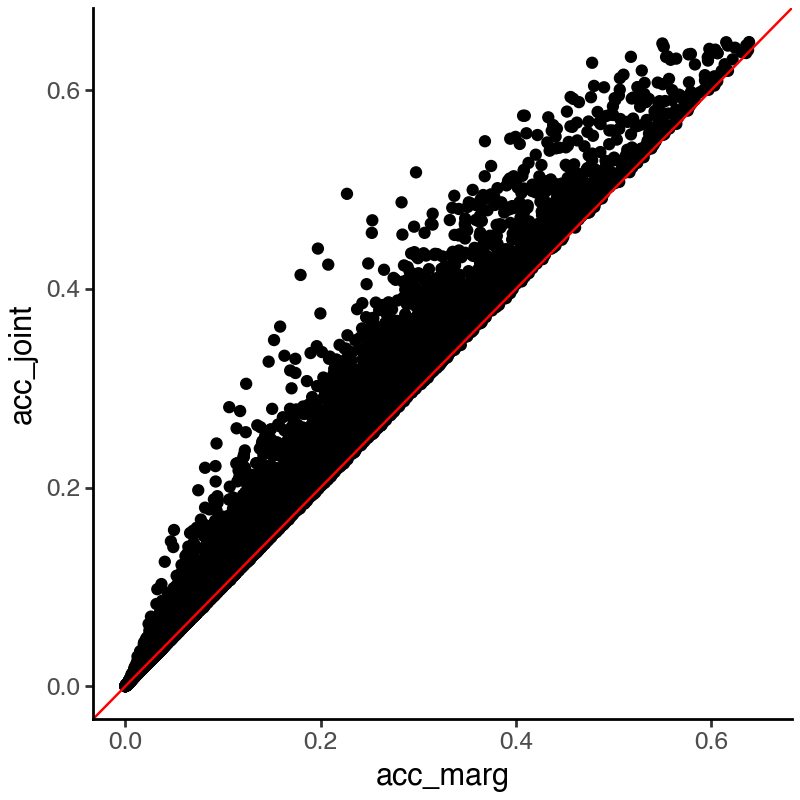

In [22]:
plotnine.options.figure_size = (4, 4)
plot=(ggplot(data = outcome_df, mapping = aes(x = 'acc_marg', y = 'acc_joint'))+
    geom_point()+ 
    geom_abline(intercept = 0, slope = 1, color = 'red')+
     scale_x_continuous(limits = (0, .65))+
     scale_y_continuous(limits = (0, .65))+
    theme_classic())
plot.show()

# Concentration-dependence

Note that in this case the non-cooperative are very strong B alone.

In [14]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm

Plot dose-response curves where we look at 1 vs 2 equal motifs, and see how the affinity changes the response.

In [9]:
affinity_range=[0.01,0.75]
affinity_limits=np.logspace(np.log10(affinity_range[0]),np.log10(affinity_range[1]),5)
print(affinity_limits)
a1_list=[2,10]
a1_limits=np.linspace(a1_list[0],a1_list[1],5)
print(a1_limits)
a2_list=[1,10]
a2_limits=np.linspace(a2_list[0],a2_list[1],5)
print(a2_limits)

[0.01       0.02942831 0.08660254 0.25485664 0.75      ]
[ 2.  4.  6.  8. 10.]
[ 1.    3.25  5.5   7.75 10.  ]


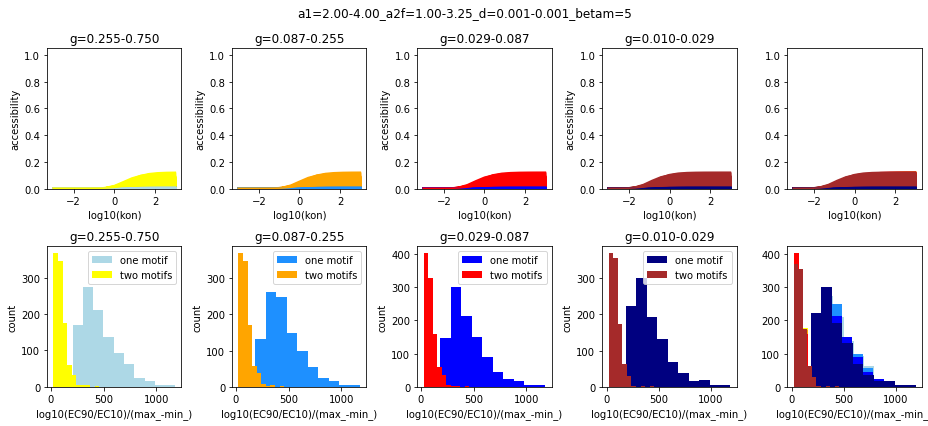

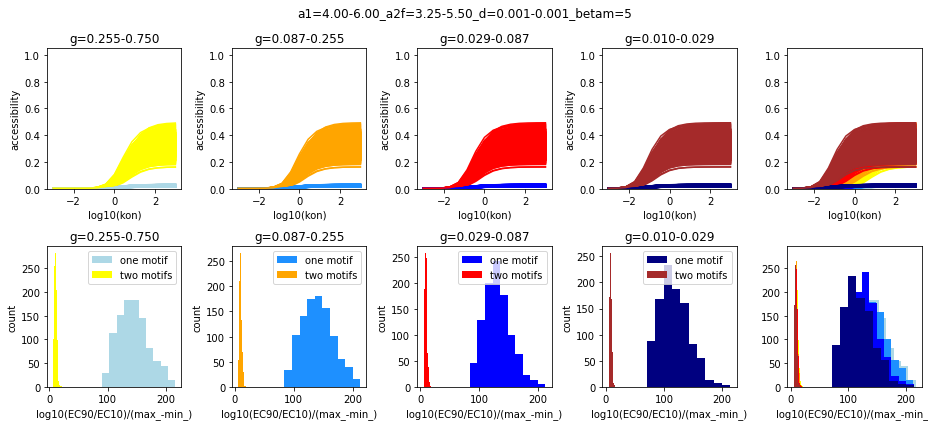

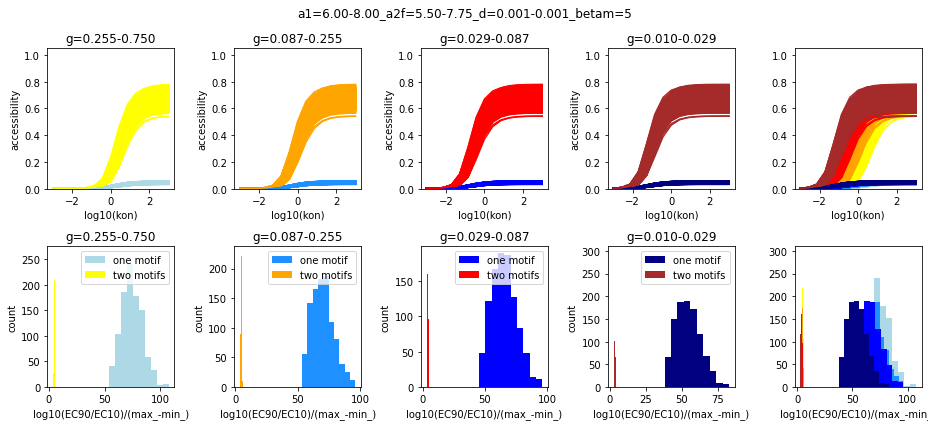

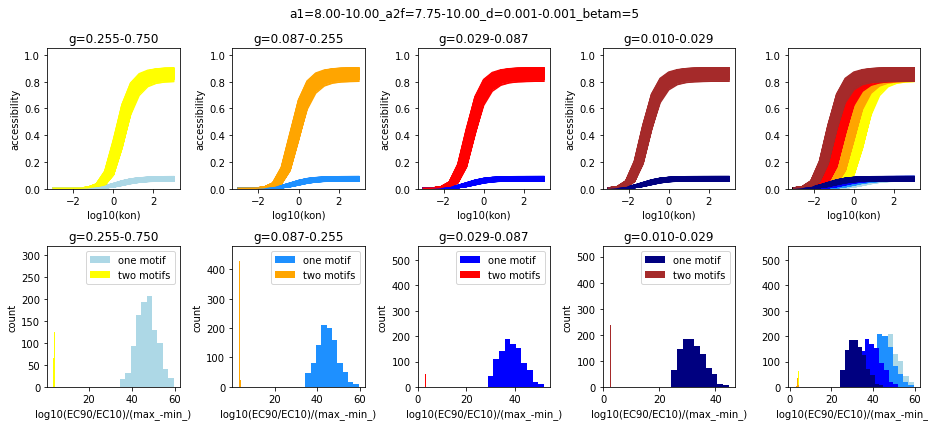

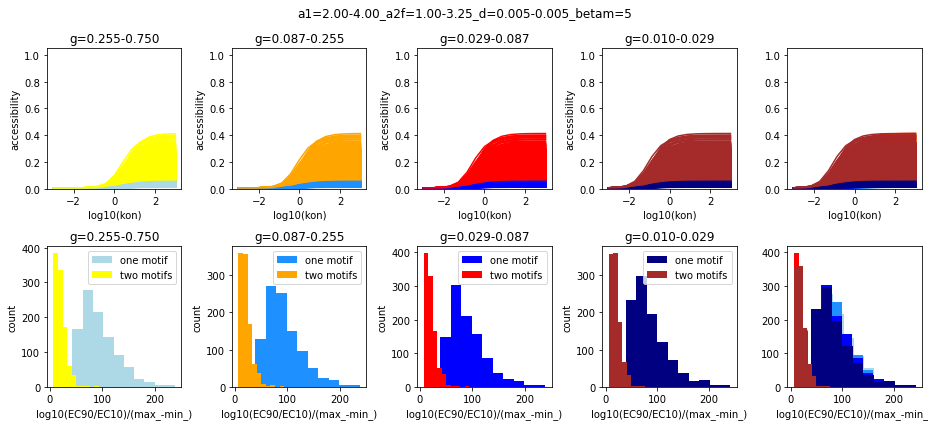

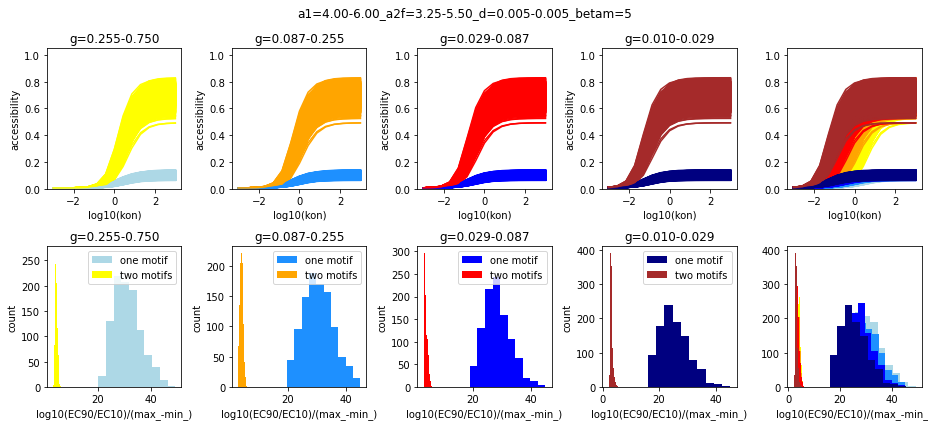

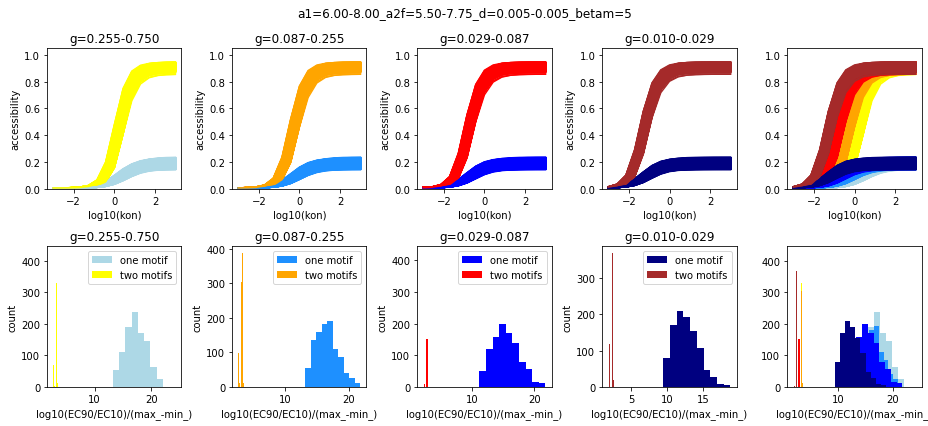

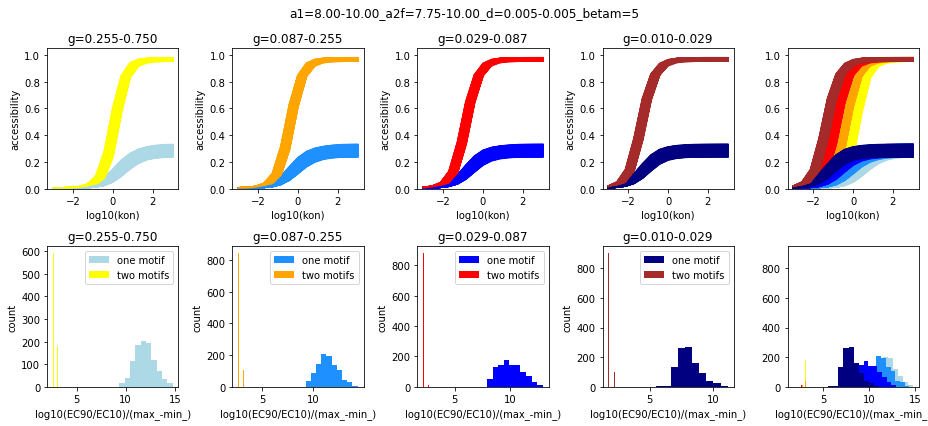

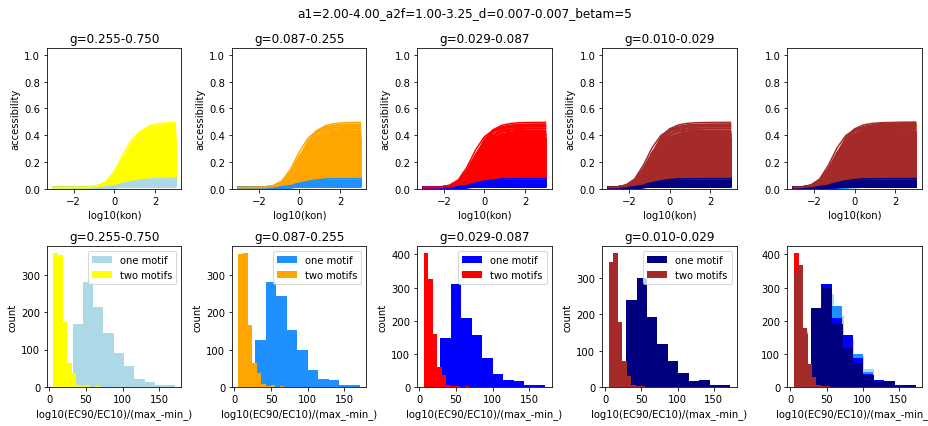

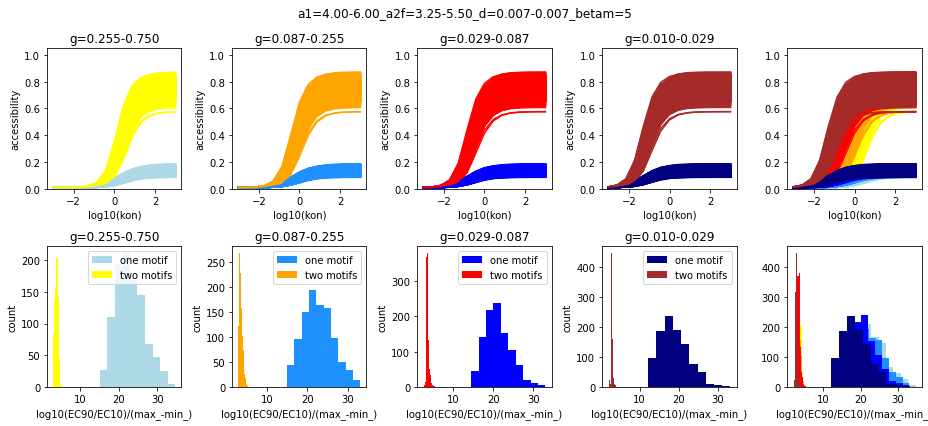

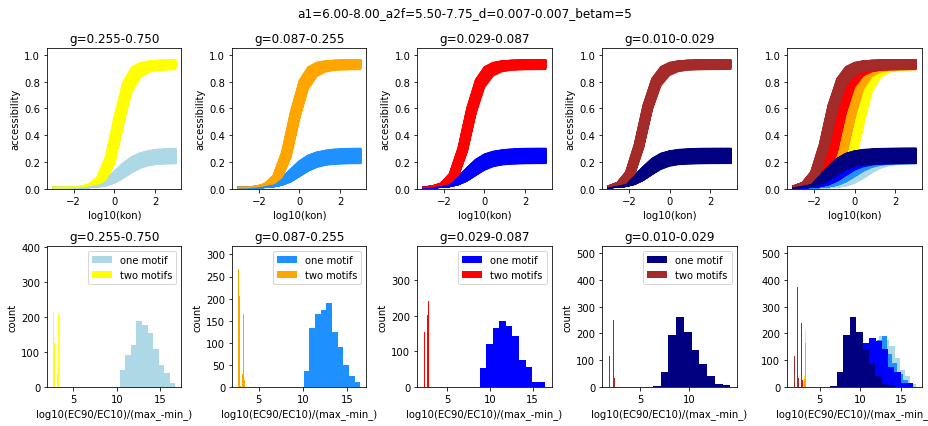

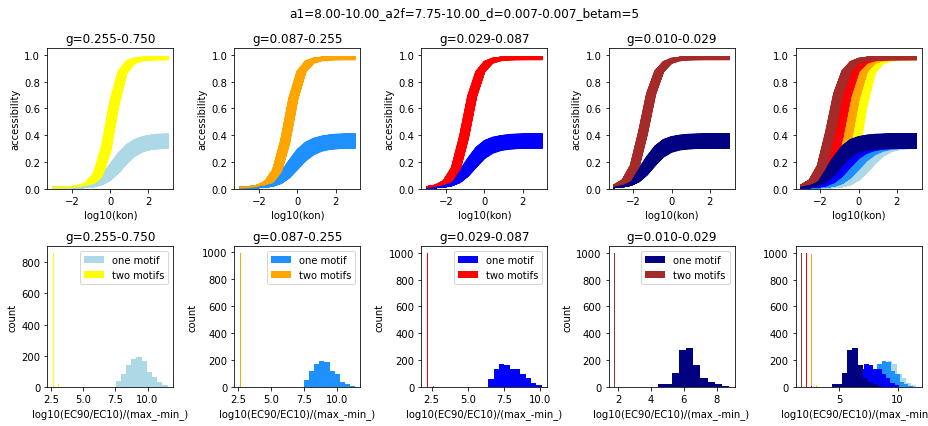

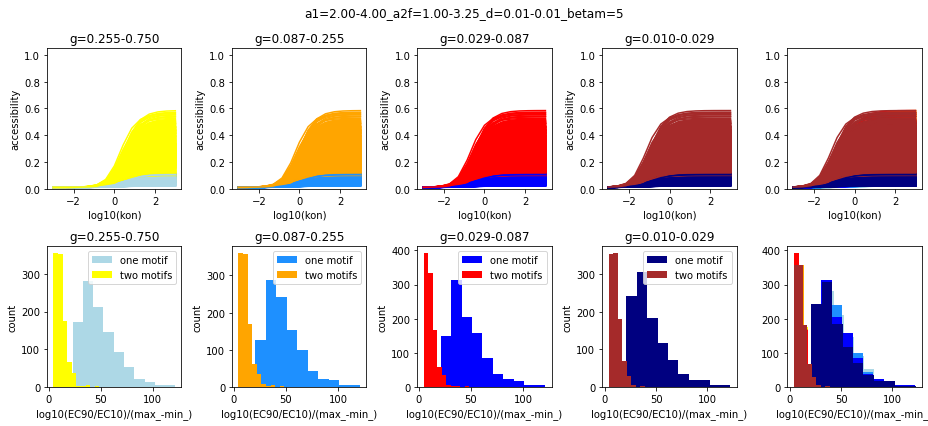

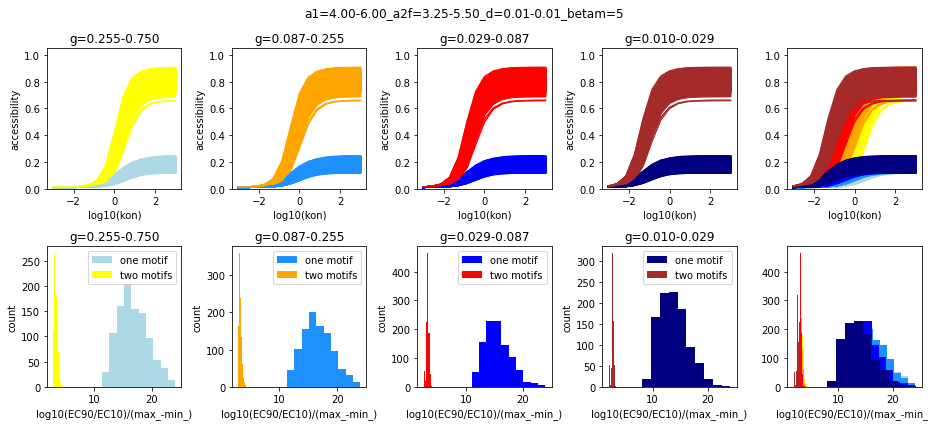

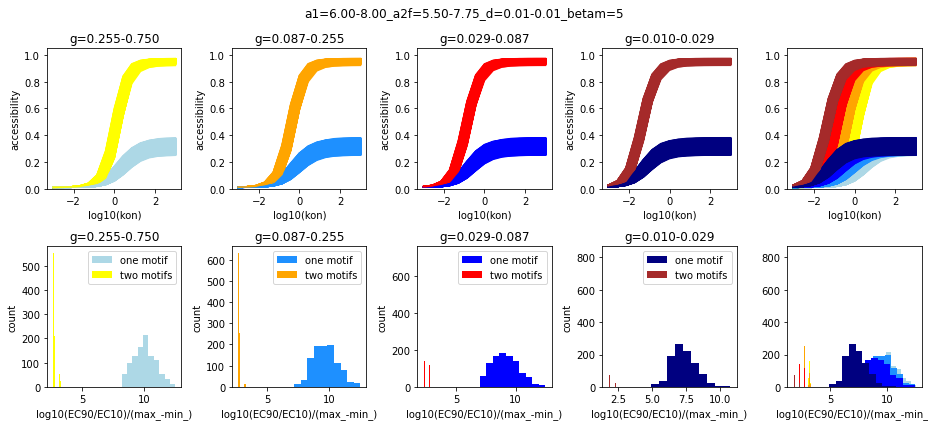

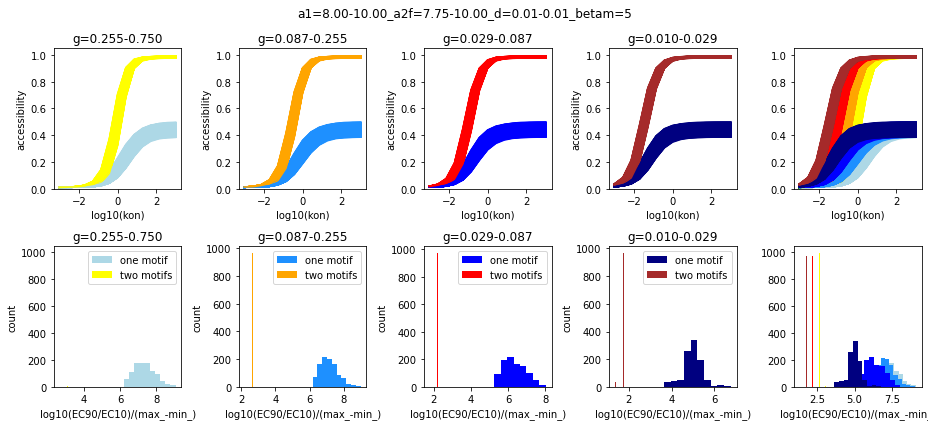

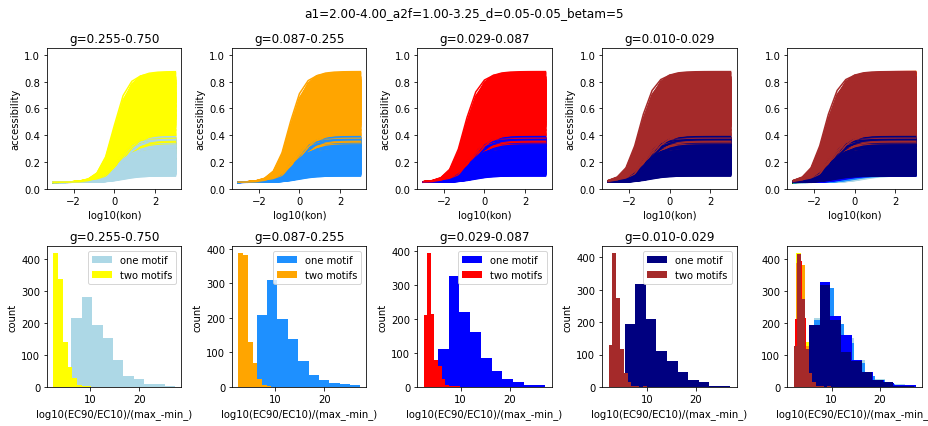

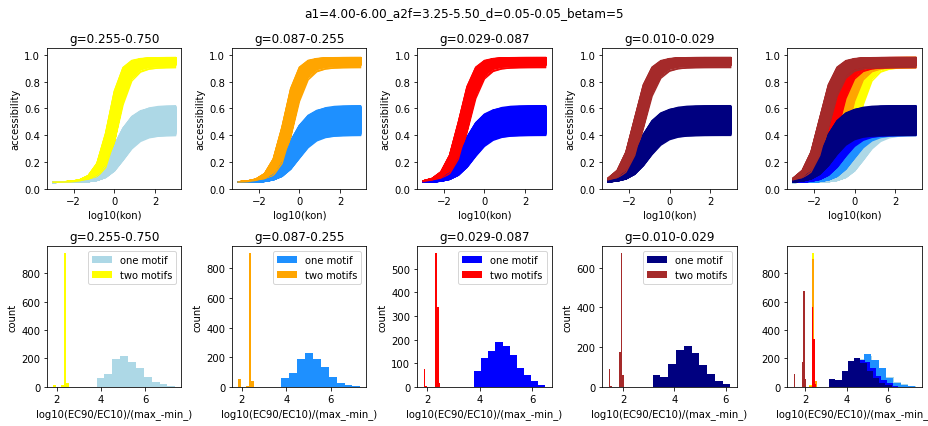

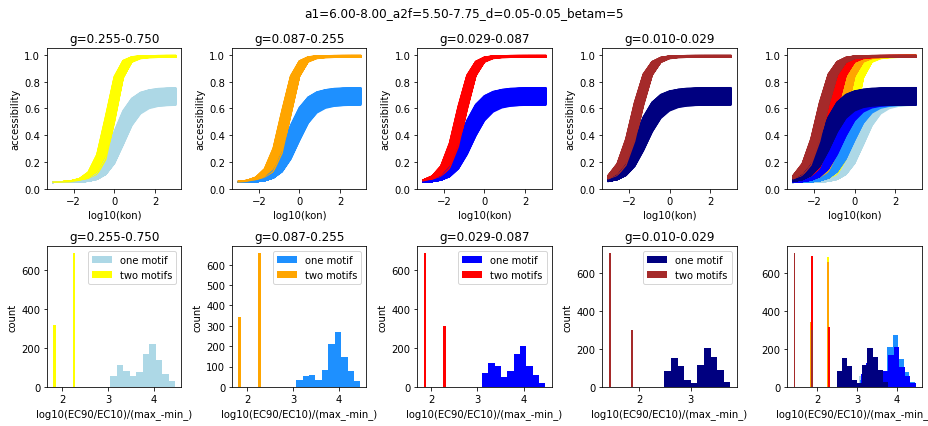

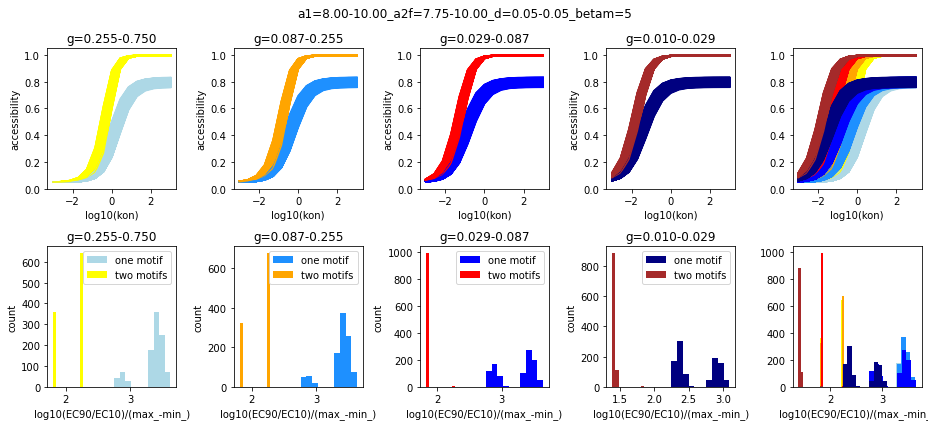

In [58]:
trial_n=1000
#d_values=[0.001,0.05]
d_values=[0.001,0.005,0.007,0.01,0.05]
betam=5
colors=["blue","red"]
labels=["one motif", "two motifs"]

colors_af=[["lightblue","dodgerblue","blue","navy"],["yellow","orange","red","brown"]]
koff=1
kon_range=np.logspace(-3,3,15)

for d in d_values:
    d_list=[d,d]
    for tier2 in range(1,5): #from weak to strong
        a1_list=[a1_limits[tier2-1],a1_limits[tier2]]
        a2f_list=[a2_limits[tier2-1],a2_limits[tier2]]
        fig,axes=plt.subplots(2,5,figsize=(13,6))
        ax_all_curves=axes[0][-1]
        ax_all_curves.set_ylim(0,1.05)
        ax_all_curves.set_xlabel("log10(kon)")
        ax_all_hist=axes[1][-1]
        suptitle="a1=%2.2f-%2.2f_a2f=%2.2f-%2.2f_d=%g-%g_betam=%g"%(tuple(a1_list+a2f_list+d_list+[betam]))
        fig.suptitle(suptitle)
        for t,tier1 in enumerate([1,2,3,4]): 
            g_list=[affinity_limits[-(tier1+1)],affinity_limits[-(tier1)]] #from low to high affinity 
            vars_for_name=g_list+a1_list+a2f_list+d_list+[betam]
            vars_for_name=tuple(vars_for_name)
            fname='g=%2.2f-%2.2f_a1=%2.2f-%2.2f_a2f=%2.2f-%2.2f_d=%g-%g_betam=%g.tsv.gz'%vars_for_name     
            all_curves = generate_input_output_2TFs_2c(gA_list=g_list, gB_list=g_list,
                                                d_list=d_list,
                                                a1A_list=a1_list, a1B_list=a1_list, 
                                                a2Af_list=a2f_list, a2Bf_list=a2f_list,
                                                betanA_list = [5,5],  betanB_list = [5,5], #likelihood to bind to the nucleosome,
                                                betamA_list = [betam,betam],  betamB_list = [betam,betam],
                                                koff=1,konrange=kon_range,
                                                trials = trial_n)
            ax=axes[0][t]
            ax.set_title("g=%2.3f-%2.3f"%tuple(g_list))
            for parset in all_curves:
                for k in range(2):
                    line=parset[k]
                    #print(line)
                    ax.plot(np.log10(kon_range),line,color=colors_af[k][t])
                    ax_all_curves.plot(np.log10(kon_range),line,color=colors_af[k][t])
                    
            ax.set_ylim(0,1.05)
            ax.set_xlabel("log10(kon)")
            ax.set_ylabel("accessibility")
            
            ax=axes[1][t]
            ax.set_title("g=%2.3f-%2.3f"%tuple(g_list))
            ax.set_xlabel("log10(EC90/EC10)/(max_-min_)")
            ax.set_ylabel("count")
            ranges=[[],[]]
            for parset in all_curves:
                for k in range(2):
                    line=parset[k]
                    min_=np.min(line)
                    max_=np.max(line)
                    t1=np.where(line>min_*1.1)[0][0]
                    t2=np.where(line<max_*0.9)[0][-1]
                    #change_range=(kon_range[t2]/kon_range[t1])
                    change_range=np.log10(kon_range[t2]/kon_range[t1])/(max_-min_)
                    ranges[k].append(change_range)
            for k in range(2):
                ax.hist(ranges[k],color=colors_af[k][t],label=labels[k])
                ax_all_hist.hist(ranges[k],color=colors_af[k][t])
            ax_all_hist.set_xlabel("log10(EC90/EC10)/(max_-min_)")
            ax.legend()
            
        plt.tight_layout()
        plt.show()

no effect on closing when bound non-specifically


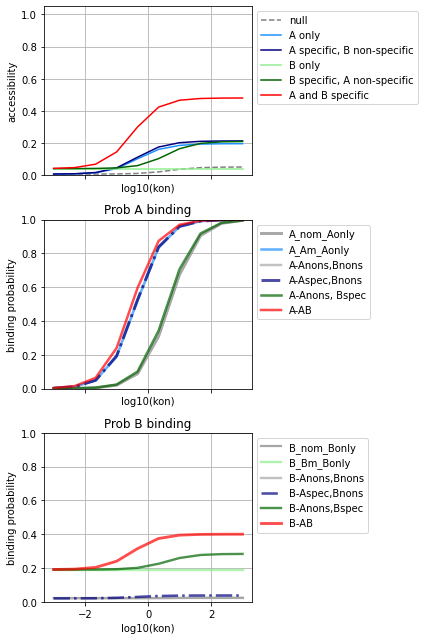

same effect on closing when bound non-specifically as when bound specifically


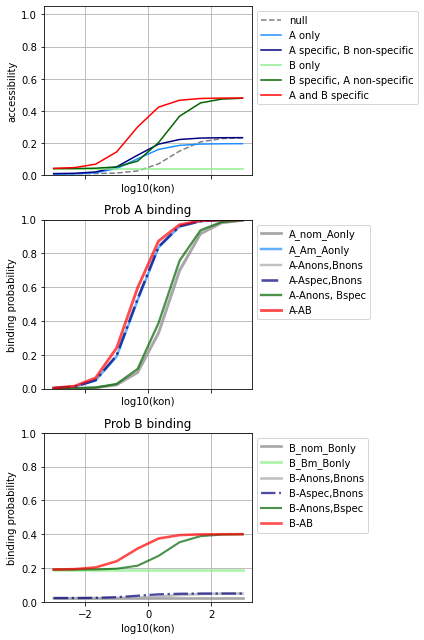

In [71]:
#Example parameter set and input-output when only TF A kon changes.
#Note the effect of the closing effect despite no motif

d=0.007
kopen0=0.05
koff=1
kclose0=kopen0/d #np.random.uniform(0.001,0.01)
    
konB=0.1
# KA=1 #np.random.uniform(1,5)
koff1nA=koff
koff1nB=koff
gA=0.1
gB=0.1
a1A=7
a1nA=a1A
a1mA=a1A
a1B=7
a1nB=a1B
a1mB=a1nB

betanA=5
betamA=5
    
betanB=5
betamB=5
h0=1
h1=1

for k in range(2):
    if k==0:
        print("no effect on closing when bound non-specifically")
        #assume some effect on the closing
        a2mAf=5
        a2nAf = 1#10 #a2mAf

        a2mBf=5
        a2nBf = 1 #10 #a2mBf
    else:
        print("same effect on closing when bound non-specifically as when bound specifically")
        a2nAf=a2mAf
        a2nBf=a2mBf

    a2nA=1/a2nAf; a2mA=1/a2mAf; a2nB=1/a2nBf; a2mB=1/a2mBf
    #assert a2nA==a2mA
    #assert a2nB==a2mB

    a1nAB=a1nA*a1nB; a1mAmB=a1mA*a1mB; a1mAnB=a1mA*a1nB; a1nAmB=a1nA*a1mB
    a2nAB=1/(a2nAf*a2nBf); a2mAnB=1/(a2mAf*a2nBf); a2nAmB=1/(a2nAf*a2mBf); a2mAmB=1/(a2mAf*a2mBf)

    parslist=[koff1nA,koff1nB,gA,gB,betanA, betanB, betamA, betamB,h0,h1, kopen0,kclose0, a1nA, a1nB, a1nAB, a1mA, a1mB, a1mAnB, a1nAmB, a1mAmB, a2nA, a2nB, a2nAB, a2mA, a2mB, a2mAnB, a2nAmB, a2mAmB]

    A0vals_=[]; AAvals_=[]; ABvals_=[]; AABvals_=[]
    AAalonevals_=[];ABalonevals_=[];
    binding_lists=[[],[],[],[],[],[],[],[],[],[],[],[]]
   
    labels_binding=["A_nom_Aonly","A_Am_Aonly","B_nom_Bonly","B_Bm_Bonly","A-Anons,Bnons","A-Aspec,Bnons","A-Anons, Bspec","A-AB","B-Anons,Bnons","B-Aspec,Bnons","B-Anons,Bspec","B-AB"]
    colors_binding=["gray","dodgerblue","gray","lightgreen","darkgray","navy","darkgreen","red","darkgray","navy","darkgreen","red"]
    cooperativity_=[]
    konrange=np.logspace(-3,3,10)
    log_kon_range=np.log10(konrange)
    konB=0.1
    for konA in konrange:

        parset=[konA,konB]+parslist

        parsetar=np.array(parset)
        if not np.all(parsetar>=0):
            negativepsets+=1
            print("negativepsets")

        else:
            parsetA=np.array([konA,koff1nA,gA,betanA,betamA, kopen0,kclose0, a1nA,a2nA, a1mA, a2mA])
            parsetB=np.array([konB,koff1nB,gB,betanB,betamB,kopen0,kclose0,a1nB,a2nB,a1mB,a2mB])
            A0_Aalone,A_Aalone,bA_Aalone_nom,bA_Aalone_Am=model_1TF_reference_nakednomotif(parsetA,idx_openconc=2,Lfunc=L_1TF_2c,returnb=True,idxs_bound=[1,3])
            A0_Balone,A_Balone,bB_Balone_nom,bB_Balone_Bm=model_1TF_reference_nakednomotif(parsetB,idx_openconc=2,Lfunc=L_1TF_2c,returnb=True,idxs_bound=[1,3])
            out =model_2TFs_reference_nakednomotif(parsetar, idx_openconc=4, Lfunc=L_2TFs_2c,returnb=True,idxs_bound=[1,3,5,7])
            A_0, A_A, A_B, A_AB=out[0:4]
            
            # A_0, A_A, A_B, A_AB, b_0, b_A, b_B, b_AB,bB_0, bB_A, bB_B, bB_AB =model_2TFs_reference_nakednomotif(parset, idx_openconc=4, Lfunc=L_2TFs_2c)
            A0vals_.append(A_0);AAvals_.append(A_A);ABvals_.append(A_B);AABvals_.append(A_AB);
            AAalonevals_.append(A_Aalone);
            ABalonevals_.append(A_Balone)
            binding_lists[0].append(bA_Aalone_nom)
            binding_lists[1].append(bA_Aalone_Am)
            binding_lists[2].append(bB_Balone_nom)
            binding_lists[3].append(bB_Balone_Bm)
            for i in range(8):
                binding_lists[i+4].append(out[i+4])
            

    fig,axes=plt.subplots(3,1,figsize=(6,9),sharex=True) #A_0, A_A, A_B, A_AB, cooperativity
    
    ax=axes[0]
    ax.plot(log_kon_range,A0vals_,linestyle="--",color="gray",label="null")
    title="acc_A"

    y=AAalonevals_
    ax.plot(log_kon_range,y,color="dodgerblue",label="A only")
    y=AAvals_
    ax.plot(log_kon_range,y,color="navy",label="A specific, B non-specific")
    y=ABalonevals_
    ax.plot(log_kon_range,y,color="lightgreen",label="B only")
    y=ABvals_
    ax.plot(log_kon_range,y,color="darkgreen",label="B specific, A non-specific")
    y=AABvals_
    ax.plot(log_kon_range,y,color="red",label="A and B specific")

    ax.legend(loc="upper left",bbox_to_anchor=(1,1),bbox_transform=ax.transAxes)                   


    ax.set_ylim(0,1.05)
    ax.set_xlabel("log10(kon)")
    ax.set_ylabel("accessibility")
    ax.grid("on")
    
    for i in range(12):
        label=labels_binding[i]
        if label[0]=="A":
            ax=axes[1]
            ax.set_title("Prob A binding")
        elif label[0]=="B":
            ax=axes[2]
            ax.set_title("Prob B binding")
        color=colors_binding[i]
        if color=="navy":
            linestyle="-."
        else:
            linestyle="-"
        ax.plot(log_kon_range,binding_lists[i],label=label,color=colors_binding[i],linewidth=2+np.random.uniform(0,1),alpha=0.7,linestyle=linestyle)
        ax.grid("on")
        ax.set_xlabel("log10(kon)")
        ax.set_ylabel("binding probability")
        
    for ax in axes[1:]:
        ax.set_ylim(0,1)
        ax.legend(loc="upper left",bbox_to_anchor=(1,1),bbox_transform=ax.transAxes)
        
        ax.grid("on")
   

    plt.tight_layout()
    plt.show()

In [73]:
affinity_range=[0.01,0.75]
affinity_limits=np.logspace(np.log10(affinity_range[0]),np.log10(affinity_range[1]),5)
print(affinity_limits)
a1_list=[2,10]
a1_limits=np.linspace(a1_list[0],a1_list[1],5)
print(a1_limits)
a2_list=[1,10]
a2_limits=np.linspace(a2_list[0],a2_list[1],5)
print(a2_limits)

[0.01       0.02942831 0.08660254 0.25485664 0.75      ]
[ 2.  4.  6.  8. 10.]
[ 1.    3.25  5.5   7.75 10.  ]


In [75]:
trial_n=5
#d_values=[0.001,0.05]
d_values=[0.001,0.005,0.007,0.01,0.05]
betam=5

koff=1
kon_range=np.logspace(-3,3,10)

for same in [True,False]:
    for d in d_values:
        d_list=[d,d]
        for tier2 in range(1,5): #from weak to strong
            a1_list=[a1_limits[tier2-1],a1_limits[tier2]]
            a2f_list=[a2_limits[tier2-1],a2_limits[tier2]]
            for t,tier1 in enumerate([1,2,3,4]): 
                g_list=[affinity_limits[-(tier1+1)],affinity_limits[-(tier1)]] #from low to high affinity 
                vars_for_name=[same]+g_list+a1_list+a2f_list+d_list+[betam]
                vars_for_name=tuple(vars_for_name)
                fname='sameclosing=%s_g=%2.2f-%2.2f_a1=%2.2f-%2.2f_a2f=%2.2f-%2.2f_d=%g-%g_betam=%g.tsv.gz'%vars_for_name     
                outcome_df = generate_input_output_2TFs_2c_Aonlychange_ns(gA_list=g_list, gB_list=g_list,
                                                    d_list=d_list,
                                                    a1A_list=a1_list, a1B_list=a1_list, 
                                                    a2Af_list=a2f_list, a2Bf_list=a2f_list,
                                                    betanA_list = [5,5],  betanB_list = [5,5], #likelihood to bind to the nucleosome,
                                                    betamA_list = [betam,betam],  betamB_list = [betam,betam],
                                                    koff=1,konrange=kon_range,
                                                    trials = trial_n,sameclosingeffect=same)
                outcome_df.to_csv(fname, sep = '\t', index = False)

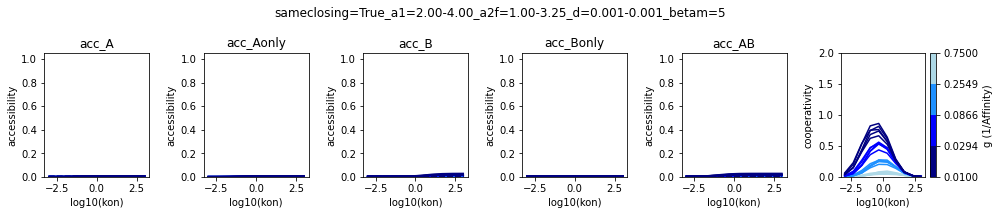

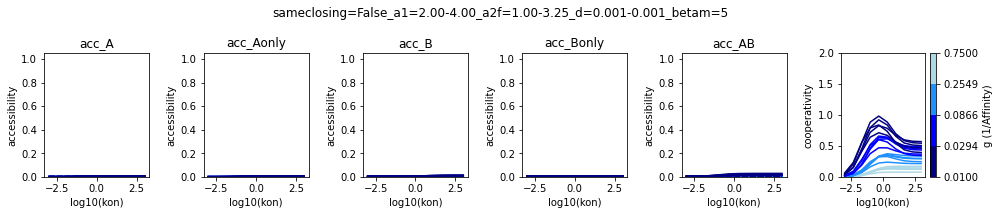

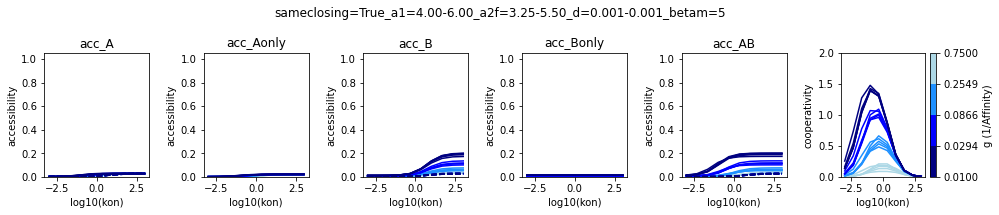

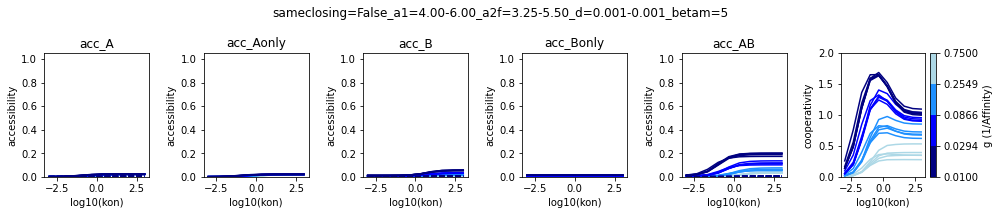

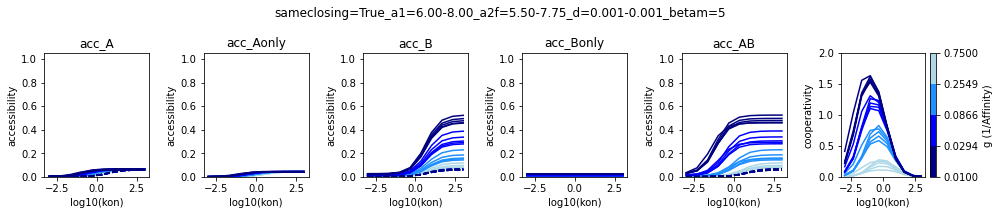

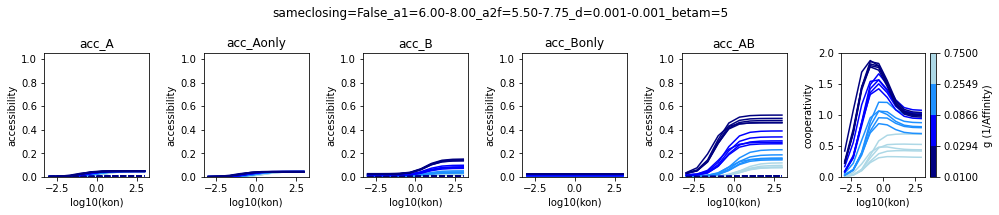

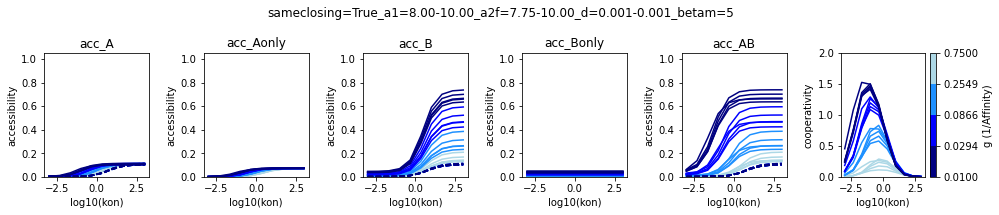

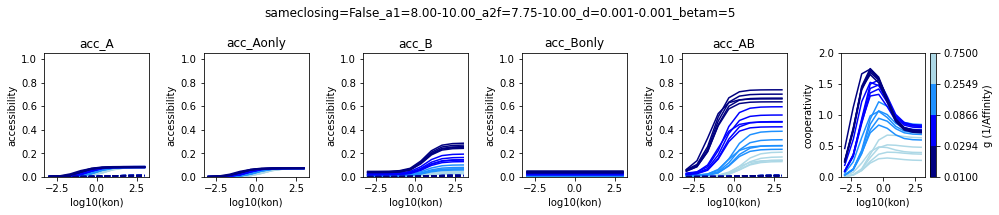

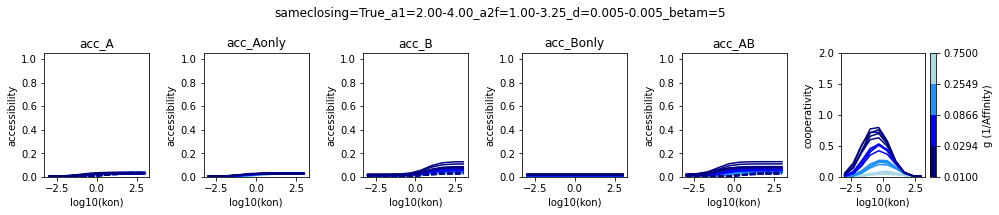

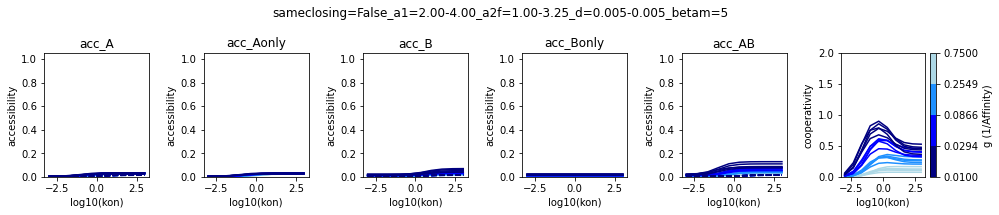

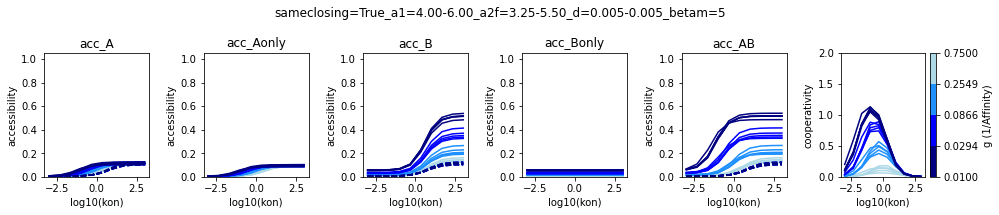

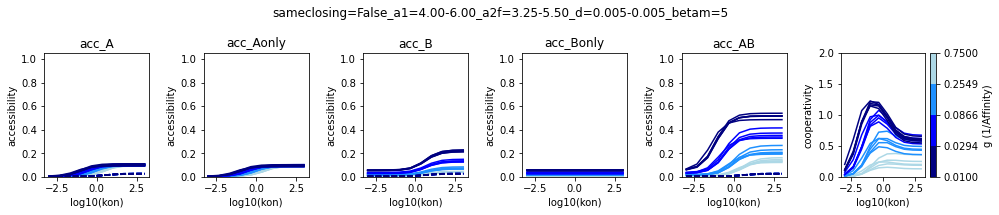

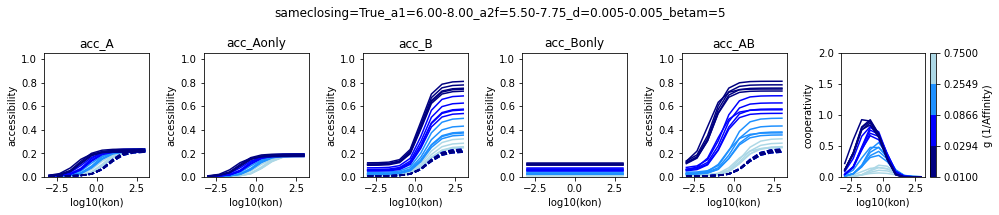

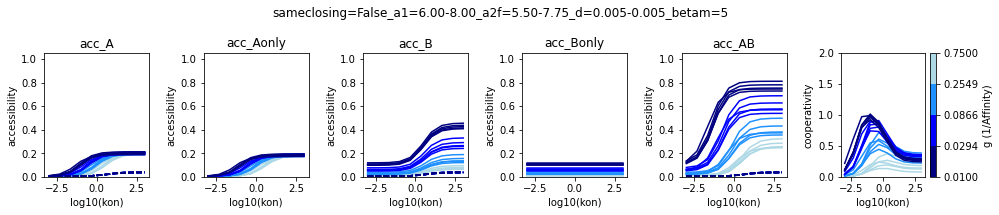

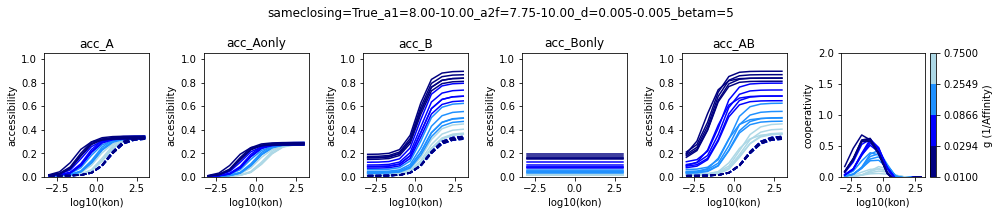

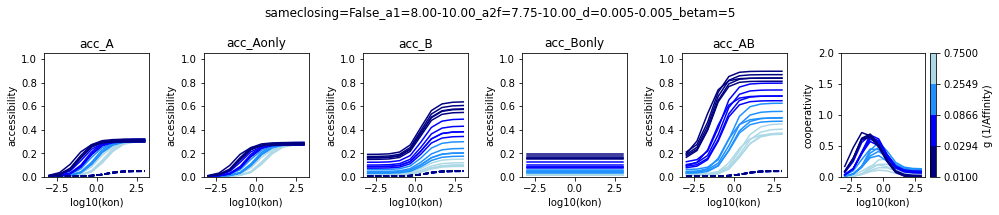

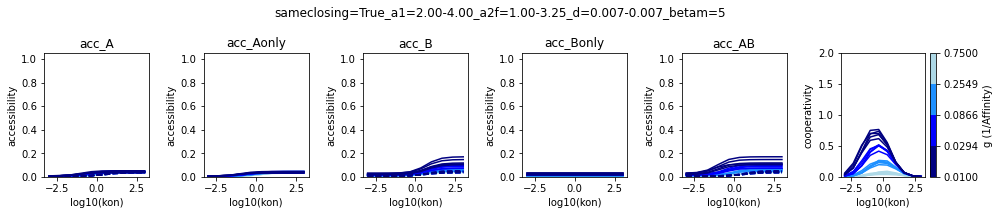

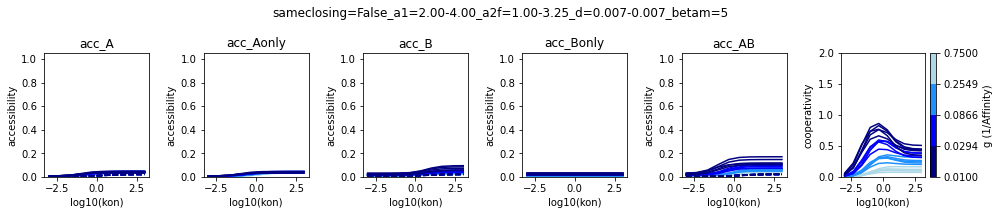

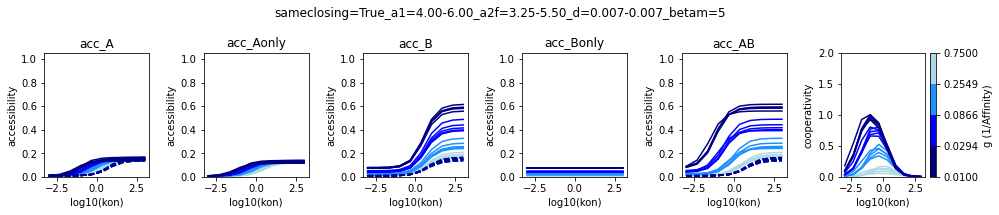

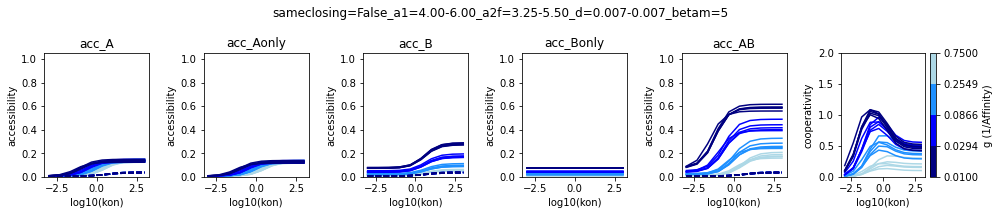

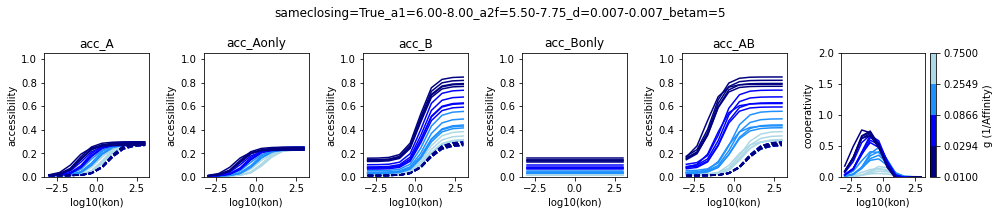

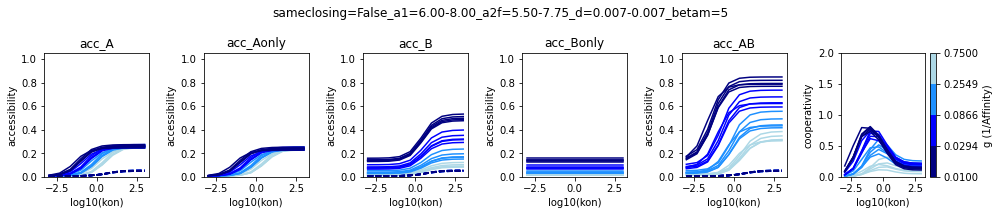

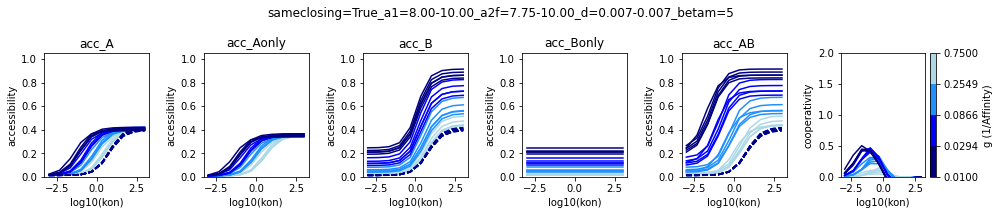

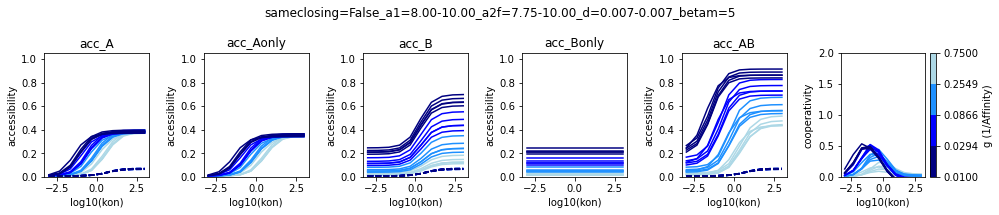

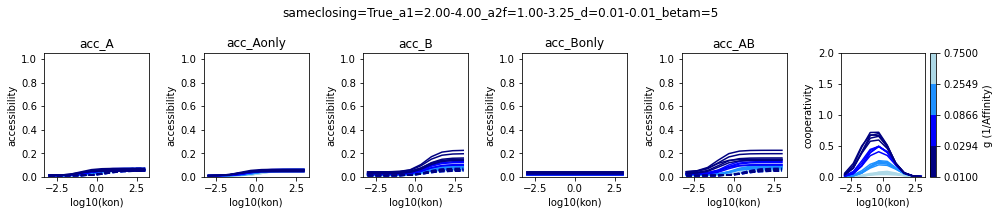

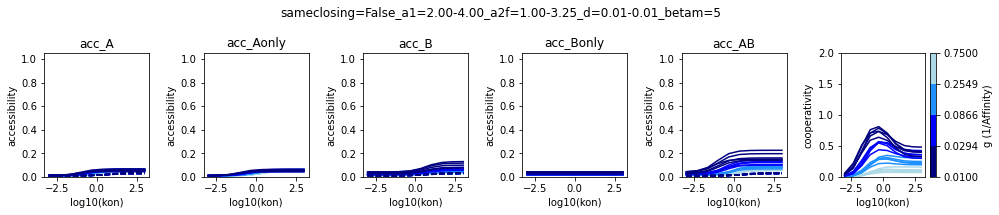

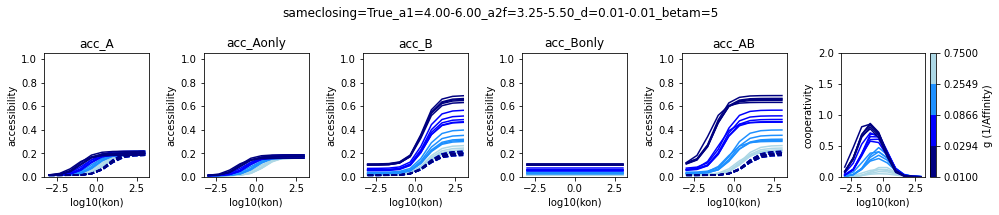

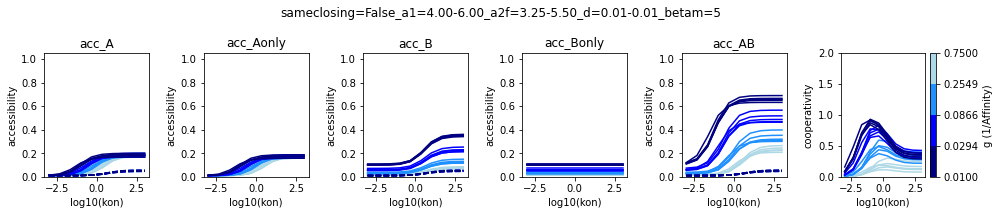

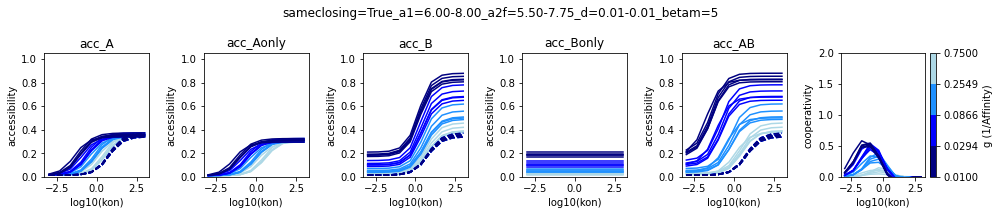

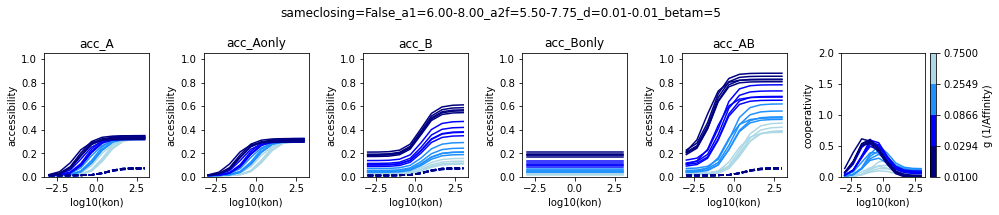

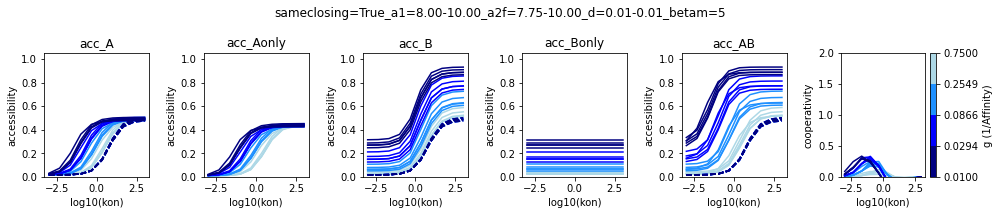

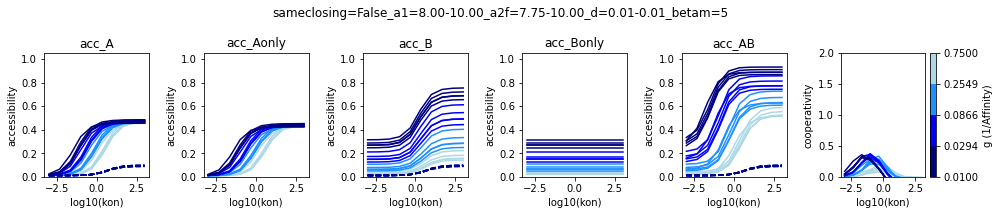

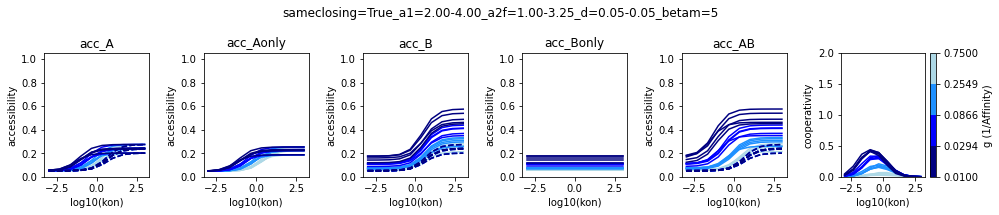

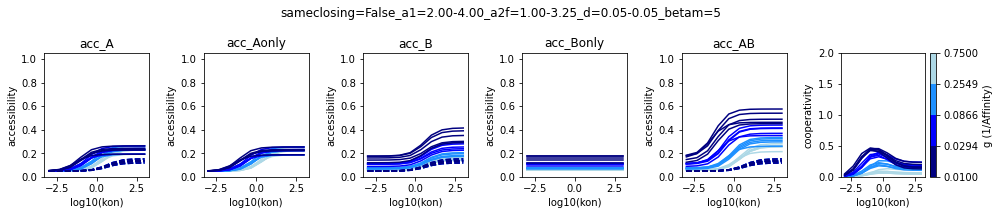

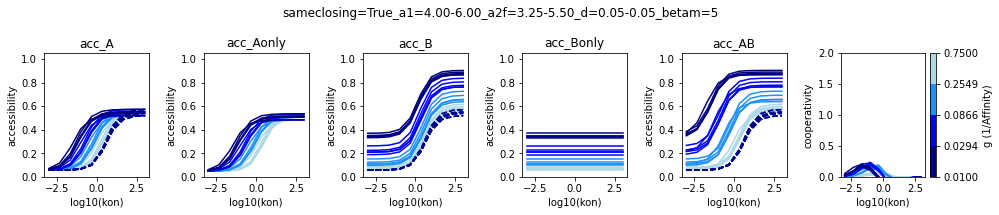

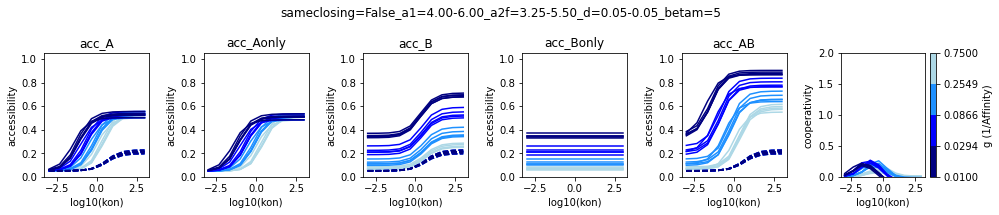

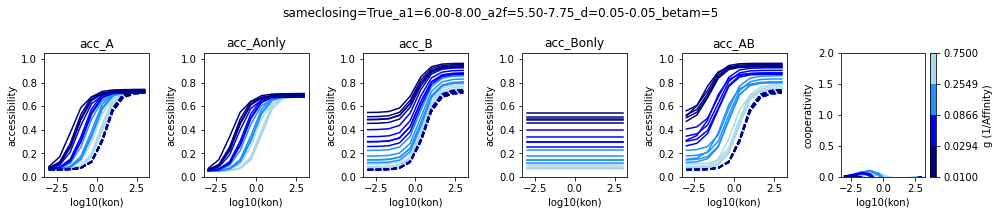

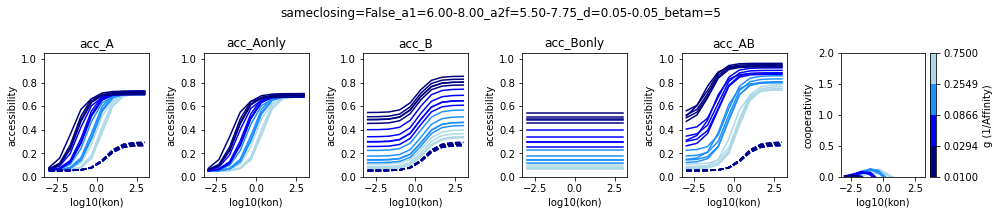

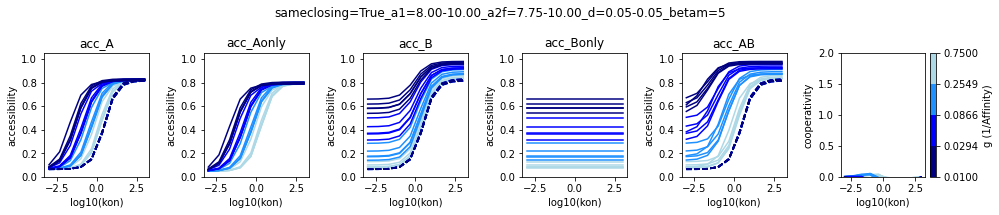

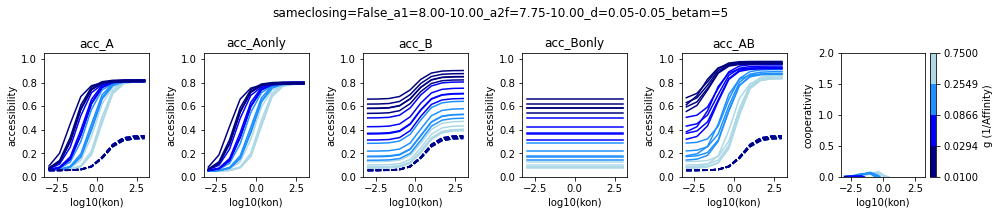

In [82]:

#d_values=[0.001,0.05]
d_values=[0.001,0.005,0.007,0.01,0.05]
betam=5
colors=["blue","red"]
labels=["one motif", "two motifs"]

colors_af=["lightblue","dodgerblue","blue","navy"]
cmap = ListedColormap(colors_af[::-1]) #boundaries need to be in increasing order, so it will start from strong to weak affinity in the colorbar
koff=1
kon_range=np.logspace(-3,3,10)
log_kon_range=np.log10(kon_range)

for d in d_values:
    d_list=[d,d]
    for tier2 in range(1,5): #from weak to strong
        a1_list=[a1_limits[tier2-1],a1_limits[tier2]]
        a2f_list=[a2_limits[tier2-1],a2_limits[tier2]]
        
        for same in [True,False]:
            fig,axes=plt.subplots(1,6,figsize=(14,3)) #A_0, A_A, A_B, A_AB, cooperativity
            suptitle="sameclosing=%s_a1=%2.2f-%2.2f_a2f=%2.2f-%2.2f_d=%g-%g_betam=%g"%(tuple([same]+a1_list+a2f_list+d_list+[betam]))
            fig.suptitle(suptitle)
            all_boundaries=[] #from largest to lowest g value, which is from lowest to highest affinity
            for t,tier1 in enumerate([1,2,3,4]): 
                g_list=[affinity_limits[-(tier1+1)],affinity_limits[-(tier1)]] #from low to high affinity 
                if t==0:
                    all_boundaries.extend(g_list[::-1]) 
                else:
                    all_boundaries.append(g_list[0])

                vars_for_name=[same]+g_list+a1_list+a2f_list+d_list+[betam]
                vars_for_name=tuple(vars_for_name)
                fname='sameclosing=%s_g=%2.2f-%2.2f_a1=%2.2f-%2.2f_a2f=%2.2f-%2.2f_d=%g-%g_betam=%g.tsv.gz'%vars_for_name 
                outcome_df=pd.read_csv(fname,compression='gzip', sep="\t")
                for i in range(len(outcome_df)):
                    row=outcome_df.iloc[i]
                    acc_null=list(map(float,row["acc_null"].split(",")))
                    for ax in axes[[0,2,4]]:
                        ax.plot(log_kon_range,acc_null,linestyle="--",color=colors_af[t])
                    for l in range(5):
                        if l==0:
                            title="acc_A"  
                        elif l==1:
                            title="acc_Aonly"
                        elif l==2:
                            title="acc_B" 
                        elif l==3:
                            title="acc_Bonly"
                        else:
                            title="acc_AB"

                        y=list(map(float,row[title].split(",")))
                        ax=axes[l]
                        ax.plot(log_kon_range,y,color=colors_af[t])
                        if i==0:
                            ax.set_title(title)
                            ax.set_ylim(0,1.05)
                            ax.set_xlabel("log10(kon)")
                            ax.set_ylabel("accessibility")
                    ax=axes[-1]
                    ax.plot(log_kon_range,list(map(float,row["acc_coopvals"].split(","))),color=colors_af[t])
                    ax.set_ylim(0,2)
                    if i==0:
                        ax.set_xlabel("log10(kon)")
                        ax.set_ylabel("cooperativity")




                    #line=parset[k]
                    #min_=np.min(line)
                    #max_=np.max(line)
                    #t1=np.where(line>min_*1.1)[0][0]
                    #t2=np.where(line<max_*0.9)[0][-1]
                    #change_range=(kon_range[t2]/kon_range[t1])
                    #change_range=np.log10(kon_range[t2]/kon_range[t1])/(max_-min_)
                    #ranges[k].append(change_range)
            ax=axes[-1]

            norm = BoundaryNorm(all_boundaries[::-1], ncolors=len(colors_af),extend='neither') #boundaries need to be in increasing order

            # ScalarMappable for colorbar
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, orientation="vertical", boundaries=all_boundaries,label="g (1/Affinity)")
            ticks = all_boundaries
            cbar.set_ticks(ticks)
            plt.tight_layout()
            plt.show()
        

In [24]:
#now pick oct-sox2 parameters
trial_n=100
affinity_range=[0.05,0.9]
affinity_limits=np.logspace(np.log10(affinity_range[0]),np.log10(affinity_range[1]),5)
betan=5
betam_list=[2,10]
a1_list=[1,10]
a2Af_list=[1,10] #assume A is octsox
a2Bf_list=[1,5]
d_list=[0.001,0.001]
kon_range=np.logspace(-3,3,25)
same=True #same closing effect when bound non-specifically as when bound specifically
for t,tier1 in enumerate([1,2,3,4]): 
    g_list=[affinity_limits[-(tier1+1)],affinity_limits[-(tier1)]] #from low to high affinity 
    vars_for_name=[same]+g_list+a1_list+a2Af_list+a2Bf_list+d_list+[betan]+betam_list
    vars_for_name=tuple(vars_for_name)
    fname='sameclosing=%s_g=%2.2f-%2.2f_a1=%2.2f-%2.2f_a2Af=%2.2f-%2.2f_a2Bf=%2.2f-%2.2f_d=%g-%g_betan=%g_betam=%g-%g.tsv.gz'%vars_for_name     
    outcome_df = generate_input_output_2TFs_2c_Aonlychange_ns(gA_list=g_list, gB_list=g_list,
                                            d_list=d_list,
                                            a1A_list=a1_list, a1B_list=a1_list, 
                                            a2Af_list=a2Af_list, a2Bf_list=a2Bf_list,
                                            betanA_list = [betan,betan],  betanB_list = [betan,betan], #likelihood to bind to the nucleosome,
                                            betamA_list = betam_list,  betamB_list = betam_list,
                                            koff=1,konrange=kon_range,
                                            trials = trial_n,sameclosingeffect=same)
    outcome_df.to_csv(fname, sep = '\t', index = False)



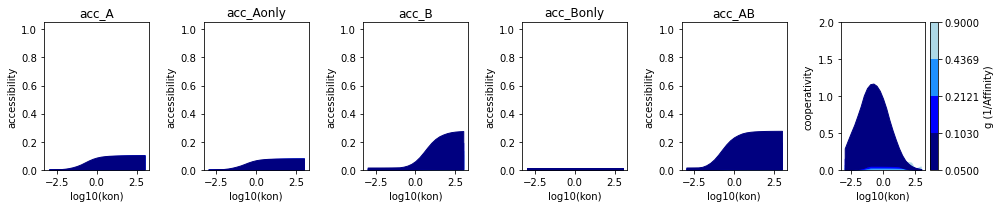

In [25]:

colors_af=["lightblue","dodgerblue","blue","navy"]
cmap = ListedColormap(colors_af[::-1]) #boundaries need to be in increasing order, so it will start from strong to weak affinity in the colorbar
log_kon_range=np.log10(kon_range)


fig,axes=plt.subplots(1,6,figsize=(14,3)) #A_0, A_A, A_B, A_AB, cooperativity
            
all_boundaries=[] #from largest to lowest g value, which is from lowest to highest affinity
for t,tier1 in enumerate([1,2,3,4]): 
    g_list=[affinity_limits[-(tier1+1)],affinity_limits[-(tier1)]] #from low to high affinity 
    vars_for_name=[same]+g_list+a1_list+a2Af_list+a2Bf_list+d_list+[betan]+betam_list
    vars_for_name=tuple(vars_for_name)
    fname='sameclosing=%s_g=%2.2f-%2.2f_a1=%2.2f-%2.2f_a2Af=%2.2f-%2.2f_a2Bf=%2.2f-%2.2f_d=%g-%g_betan=%g_betam=%g-%g.tsv.gz'%vars_for_name     

    if t==0:
        all_boundaries.extend(g_list[::-1]) 
    else:
        all_boundaries.append(g_list[0])

    titles=["acc_A","acc_Aonly","acc_B","acc_Bonly","acc_AB","acc_coopvals"]
    lines_dict={title:[] for title in titles}
    outcome_df=pd.read_csv(fname,compression='gzip', sep="\t")
    for i in range(len(outcome_df)):
        row=outcome_df.iloc[i]
        for title in titles:
            y=list(map(float,row[title].split(",")))
            lines_dict[title].append(y)
    for l, title in enumerate(titles):
        data=lines_dict[title]
        data=np.array(data)
        min_=data.min(axis=0)
        max_=data.max(axis=0)
        ax=axes[l]
        ax.fill_between(log_kon_range,min_,max_,color=colors_af[t])
        
for a,ax in enumerate(axes[0:5]):
    ax.set_title(titles[a])
    ax.set_ylim(0,1.05)
    ax.set_xlabel("log10(kon)")
    ax.set_ylabel("accessibility")
ax=axes[-1]
ax.set_ylim(0,2)

ax.set_xlabel("log10(kon)")
ax.set_ylabel("cooperativity")


norm = BoundaryNorm(all_boundaries[::-1], ncolors=len(colors_af),extend='neither') #boundaries need to be in increasing order

# ScalarMappable for colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", boundaries=all_boundaries,label="g (1/Affinity)")
ticks = all_boundaries
cbar.set_ticks(ticks)
plt.tight_layout()
plt.show()

In [26]:
#now pick intermediate strengths (a1,a2)
trial_n=100
affinity_range=[0.05,0.9]
affinity_limits=np.logspace(np.log10(affinity_range[0]),np.log10(affinity_range[1]),5)
betan=5
betam_list=[2,10]
a1_list=[5,7]
a2Af_list=[2,4] #assume A is octsox
a2Bf_list=[2,4]
d_list=[0.001,0.001]
kon_range=np.logspace(-3,3,25)
same=True #same closing effect when bound non-specifically as when bound specifically
for t,tier1 in enumerate([1,2,3,4]): 
    g_list=[affinity_limits[-(tier1+1)],affinity_limits[-(tier1)]] #from low to high affinity 
    vars_for_name=[same]+g_list+a1_list+a2Af_list+a2Bf_list+d_list+[betan]+betam_list
    vars_for_name=tuple(vars_for_name)
    fname='sameclosing=%s_g=%2.2f-%2.2f_a1=%2.2f-%2.2f_a2Af=%2.2f-%2.2f_a2Bf=%2.2f-%2.2f_d=%g-%g_betan=%g_betam=%g-%g.tsv.gz'%vars_for_name     
    outcome_df = generate_input_output_2TFs_2c_Aonlychange_ns(gA_list=g_list, gB_list=g_list,
                                            d_list=d_list,
                                            a1A_list=a1_list, a1B_list=a1_list, 
                                            a2Af_list=a2Af_list, a2Bf_list=a2Bf_list,
                                            betanA_list = [betan,betan],  betanB_list = [betan,betan], #likelihood to bind to the nucleosome,
                                            betamA_list = betam_list,  betamB_list = betam_list,
                                            koff=1,konrange=kon_range,
                                            trials = trial_n,sameclosingeffect=same)
    outcome_df.to_csv(fname, sep = '\t', index = False)



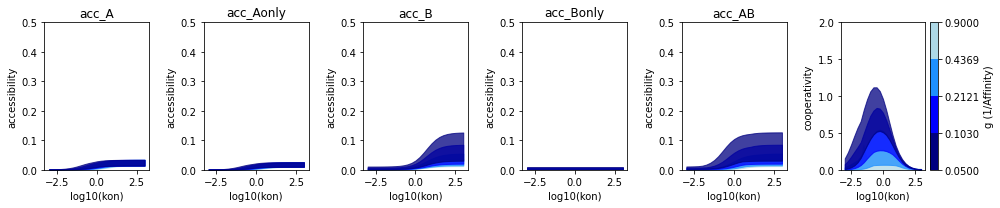

In [32]:
colors_af=["lightblue","dodgerblue","blue","navy"]
cmap = ListedColormap(colors_af[::-1]) #boundaries need to be in increasing order, so it will start from strong to weak affinity in the colorbar
log_kon_range=np.log10(kon_range)


fig,axes=plt.subplots(1,6,figsize=(14,3)) #A_0, A_A, A_B, A_AB, cooperativity
            
all_boundaries=[] #from largest to lowest g value, which is from lowest to highest affinity
for t,tier1 in enumerate([1,2,3,4]): 
    g_list=[affinity_limits[-(tier1+1)],affinity_limits[-(tier1)]] #from low to high affinity 
    vars_for_name=[same]+g_list+a1_list+a2Af_list+a2Bf_list+d_list+[betan]+betam_list
    vars_for_name=tuple(vars_for_name)
    fname='sameclosing=%s_g=%2.2f-%2.2f_a1=%2.2f-%2.2f_a2Af=%2.2f-%2.2f_a2Bf=%2.2f-%2.2f_d=%g-%g_betan=%g_betam=%g-%g.tsv.gz'%vars_for_name     

    if t==0:
        all_boundaries.extend(g_list[::-1]) 
    else:
        all_boundaries.append(g_list[0])

    titles=["acc_A","acc_Aonly","acc_B","acc_Bonly","acc_AB","acc_coopvals"]
    lines_dict={title:[] for title in titles}
    outcome_df=pd.read_csv(fname,compression='gzip', sep="\t")
    for i in range(len(outcome_df)):
        row=outcome_df.iloc[i]
        for title in titles:
            y=list(map(float,row[title].split(",")))
            lines_dict[title].append(y)
    for l, title in enumerate(titles):
        data=lines_dict[title]
        data=np.array(data)
        min_=data.min(axis=0)
        max_=data.max(axis=0)
        ax=axes[l]
        ax.fill_between(log_kon_range,min_,max_,color=colors_af[t],alpha=0.75)
        
for a,ax in enumerate(axes[0:5]):
    ax.set_title(titles[a])
    ax.set_ylim(0,0.5)
    ax.set_xlabel("log10(kon)")
    ax.set_ylabel("accessibility")
ax=axes[-1]
ax.set_ylim(0,2)

ax.set_xlabel("log10(kon)")
ax.set_ylabel("cooperativity")


norm = BoundaryNorm(all_boundaries[::-1], ncolors=len(colors_af),extend='neither') #boundaries need to be in increasing order

# ScalarMappable for colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", boundaries=all_boundaries,label="g (1/Affinity)")
ticks = all_boundaries
cbar.set_ticks(ticks)
plt.tight_layout()
plt.show()

In [35]:
#now pick intermediate strengths (a1,a2), betam=5
trial_n=1000
affinity_range=[0.05,0.9]
affinity_limits=np.logspace(np.log10(affinity_range[0]),np.log10(affinity_range[1]),5)
betan=5
betam_list=[5,5]
a1_list=[5,7]
a2Af_list=[2,4] #assume A is octsox
a2Bf_list=[2,4]
d_list=[0.001,0.001]
kon_range=np.logspace(-3,3,25)
same=True #same closing effect when bound non-specifically as when bound specifically
for t,tier1 in enumerate([1,2,3,4]): 
    g_list=[affinity_limits[-(tier1+1)],affinity_limits[-(tier1)]] #from low to high affinity 
    vars_for_name=[same]+g_list+a1_list+a2Af_list+a2Bf_list+d_list+[betan]+betam_list
    vars_for_name=tuple(vars_for_name)
    fname='sameclosing=%s_g=%2.2f-%2.2f_a1=%2.2f-%2.2f_a2Af=%2.2f-%2.2f_a2Bf=%2.2f-%2.2f_d=%g-%g_betan=%g_betam=%g-%g.tsv.gz'%vars_for_name     
    outcome_df = generate_input_output_2TFs_2c_Aonlychange_ns(gA_list=g_list, gB_list=g_list,
                                            d_list=d_list,
                                            a1A_list=a1_list, a1B_list=a1_list, 
                                            a2Af_list=a2Af_list, a2Bf_list=a2Bf_list,
                                            betanA_list = [betan,betan],  betanB_list = [betan,betan], #likelihood to bind to the nucleosome,
                                            betamA_list = betam_list,  betamB_list = betam_list,
                                            koff=1,konrange=kon_range,
                                            trials = trial_n,sameclosingeffect=same)
    outcome_df.to_csv(fname, sep = '\t', index = False)



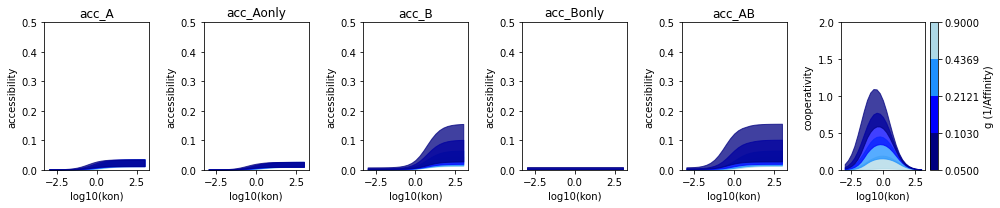

In [36]:
colors_af=["lightblue","dodgerblue","blue","navy"]
cmap = ListedColormap(colors_af[::-1]) #boundaries need to be in increasing order, so it will start from strong to weak affinity in the colorbar
log_kon_range=np.log10(kon_range)


fig,axes=plt.subplots(1,6,figsize=(14,3)) #A_0, A_A, A_B, A_AB, cooperativity
            
all_boundaries=[] #from largest to lowest g value, which is from lowest to highest affinity
for t,tier1 in enumerate([1,2,3,4]): 
    g_list=[affinity_limits[-(tier1+1)],affinity_limits[-(tier1)]] #from low to high affinity 
    vars_for_name=[same]+g_list+a1_list+a2Af_list+a2Bf_list+d_list+[betan]+betam_list
    vars_for_name=tuple(vars_for_name)
    fname='sameclosing=%s_g=%2.2f-%2.2f_a1=%2.2f-%2.2f_a2Af=%2.2f-%2.2f_a2Bf=%2.2f-%2.2f_d=%g-%g_betan=%g_betam=%g-%g.tsv.gz'%vars_for_name     

    if t==0:
        all_boundaries.extend(g_list[::-1]) 
    else:
        all_boundaries.append(g_list[0])

    titles=["acc_A","acc_Aonly","acc_B","acc_Bonly","acc_AB","acc_coopvals"]
    lines_dict={title:[] for title in titles}
    outcome_df=pd.read_csv(fname,compression='gzip', sep="\t")
    for i in range(len(outcome_df)):
        row=outcome_df.iloc[i]
        for title in titles:
            y=list(map(float,row[title].split(",")))
            lines_dict[title].append(y)
    for l, title in enumerate(titles):
        data=lines_dict[title]
        data=np.array(data)
        min_=data.min(axis=0)
        max_=data.max(axis=0)
        ax=axes[l]
        ax.fill_between(log_kon_range,min_,max_,color=colors_af[t],alpha=0.75)
        
for a,ax in enumerate(axes[0:5]):
    ax.set_title(titles[a])
    ax.set_ylim(0,0.5)
    ax.set_xlabel("log10(kon)")
    ax.set_ylabel("accessibility")
ax=axes[-1]
ax.set_ylim(0,2)

ax.set_xlabel("log10(kon)")
ax.set_ylabel("cooperativity")


norm = BoundaryNorm(all_boundaries[::-1], ncolors=len(colors_af),extend='neither') #boundaries need to be in increasing order

# ScalarMappable for colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", boundaries=all_boundaries,label="g (1/Affinity)")
ticks = all_boundaries
cbar.set_ticks(ticks)
plt.tight_layout()
plt.show()

In [16]:
affinity_range=[0.01,0.75]
affinity_limits=np.logspace(np.log10(affinity_range[0]),np.log10(affinity_range[1]),5)
print(affinity_limits)
a1_list=[2,10]
a1_limits=np.linspace(a1_list[0],a1_list[1],5)
print(a1_limits)
a2_list=[1,10]
a2_limits=np.linspace(a2_list[0],a2_list[1],5)
print(a2_limits)

[0.01       0.02942831 0.08660254 0.25485664 0.75      ]
[ 2.  4.  6.  8. 10.]
[ 1.    3.25  5.5   7.75 10.  ]


In [19]:
trial_n=10
#d_values=[0.001,0.05]
d_values=[0.01]
betam=5
gB_list=[0.1,0.1]

koff=1
kon_range=np.logspace(-3,3,10)

for same in [True]:
    for d in [0.01]:
        d_list=[d,d]
        for tier2 in range(1,5): #from weak to strong
            a1_list=[a1_limits[tier2-1],a1_limits[tier2]]
            a2f_list=[a2_limits[tier2-1],a2_limits[tier2]]
            for t,tier1 in enumerate([1,2,3,4]): 
                gA_list=[affinity_limits[-(tier1+1)],affinity_limits[-(tier1)]] #from low to high affinity 
                
                vars_for_name=[same]+gA_list+gB_list+a1_list+a2f_list+d_list+[betam]
                vars_for_name=tuple(vars_for_name)
                fname='sameclosing=%s_gA=%2.2f-%2.2f_gB=%2.2f-%2.2f_a1=%2.2f-%2.2f_a2f=%2.2f-%2.2f_d=%g-%g_betam=%g.tsv.gz'%vars_for_name     
                outcome_df = generate_input_output_2TFs_2c_Aonlychange_ns(gA_list=gA_list, gB_list=gB_list,
                                                    d_list=d_list,
                                                    a1A_list=a1_list, a1B_list=a1_list, 
                                                    a2Af_list=a2f_list, a2Bf_list=a2f_list,
                                                    betanA_list = [5,5],  betanB_list = [5,5], #likelihood to bind to the nucleosome,
                                                    betamA_list = [betam,betam],  betamB_list = [betam,betam],
                                                    koff=1,konrange=kon_range,
                                                    trials = trial_n,sameclosingeffect=same)
                outcome_df.to_csv(fname, sep = '\t', index = False)

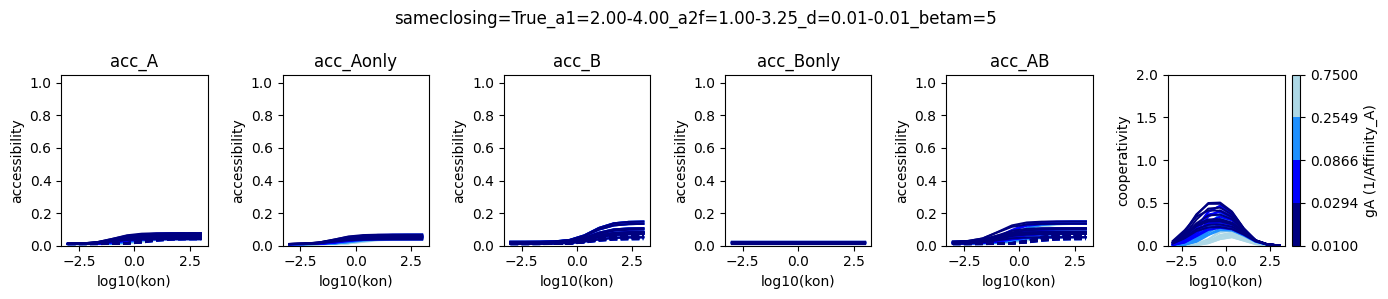

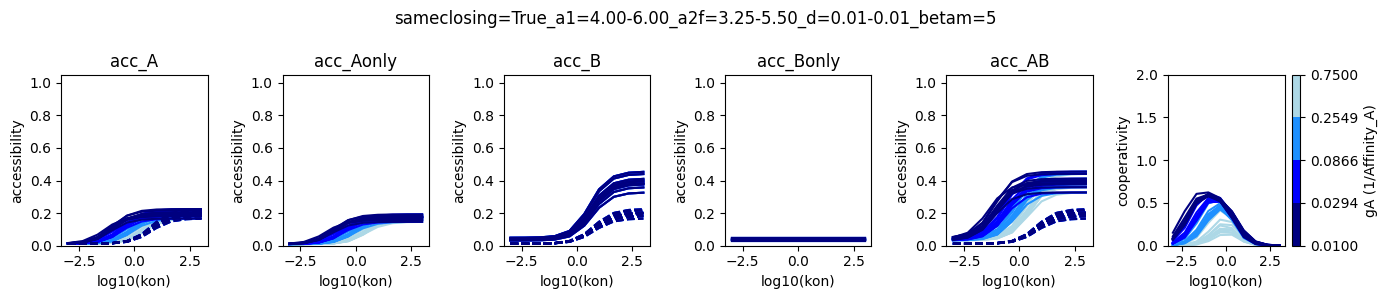

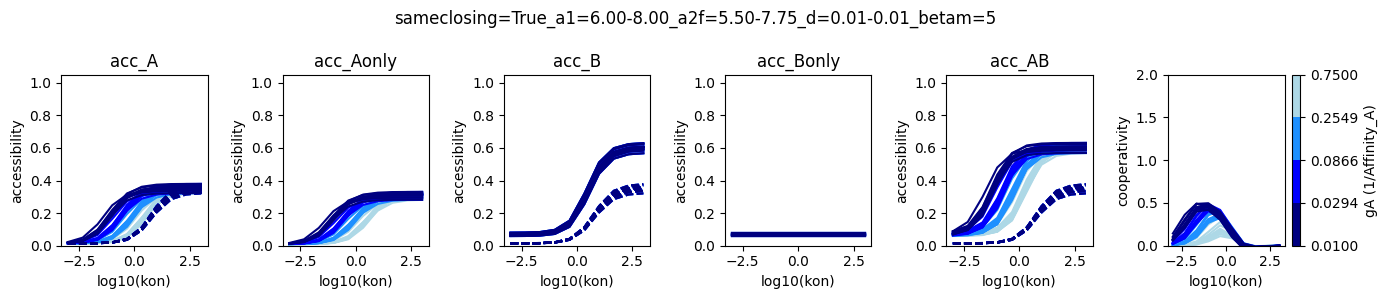

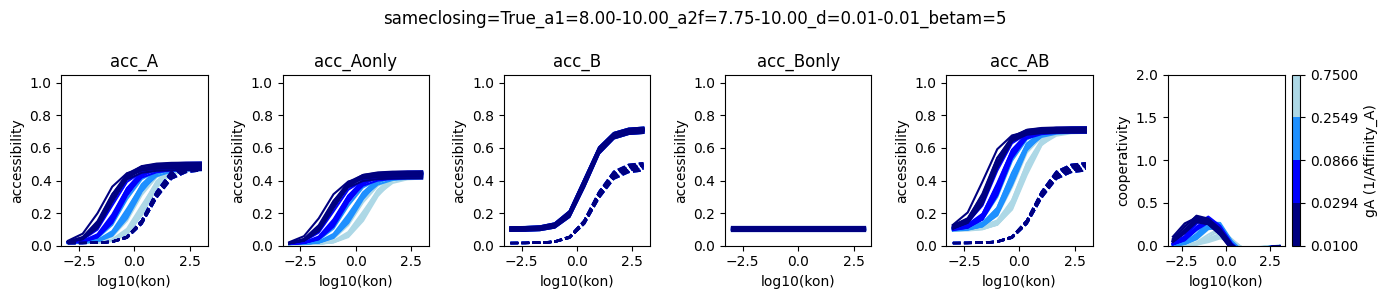

In [22]:

#d_values=[0.001,0.05]
d_values=[0.01]
betam=5
colors=["blue","red"]
labels=["one motif", "two motifs"]

colors_af=["lightblue","dodgerblue","blue","navy"]
cmap = ListedColormap(colors_af[::-1]) #boundaries need to be in increasing order, so it will start from strong to weak affinity in the colorbar
koff=1
kon_range=np.logspace(-3,3,10)
log_kon_range=np.log10(kon_range)

for d in d_values:
    d_list=[d,d]
    for tier2 in range(1,5): #from weak to strong
        a1_list=[a1_limits[tier2-1],a1_limits[tier2]]
        a2f_list=[a2_limits[tier2-1],a2_limits[tier2]]
        
        for same in [True]:
            fig,axes=plt.subplots(1,6,figsize=(14,3)) #A_0, A_A, A_B, A_AB, cooperativity
            suptitle="sameclosing=%s_a1=%2.2f-%2.2f_a2f=%2.2f-%2.2f_d=%g-%g_betam=%g"%(tuple([same]+a1_list+a2f_list+d_list+[betam]))
            fig.suptitle(suptitle)
            all_boundaries=[] #from largest to lowest g value, which is from lowest to highest affinity
            for t,tier1 in enumerate([1,2,3,4]): 
                gA_list=[affinity_limits[-(tier1+1)],affinity_limits[-(tier1)]] #from low to high affinity 
                
                if t==0:
                    all_boundaries.extend(gA_list[::-1]) 
                else:
                    all_boundaries.append(gA_list[0])

                vars_for_name=[same]+gA_list+gB_list+a1_list+a2f_list+d_list+[betam]
                vars_for_name=tuple(vars_for_name)
                fname='sameclosing=%s_gA=%2.2f-%2.2f_gB=%2.2f-%2.2f_a1=%2.2f-%2.2f_a2f=%2.2f-%2.2f_d=%g-%g_betam=%g.tsv.gz'%vars_for_name 
                outcome_df=pd.read_csv(fname,compression='gzip', sep="\t")
                for i in range(len(outcome_df)):
                    row=outcome_df.iloc[i]
                    acc_null=list(map(float,row["acc_null"].split(",")))
                    for ax in axes[[0,2,4]]:
                        ax.plot(log_kon_range,acc_null,linestyle="--",color=colors_af[t])
                    for l in range(5):
                        if l==0:
                            title="acc_A"  
                        elif l==1:
                            title="acc_Aonly"
                        elif l==2:
                            title="acc_B" 
                        elif l==3:
                            title="acc_Bonly"
                        else:
                            title="acc_AB"

                        y=list(map(float,row[title].split(",")))
                        ax=axes[l]
                        ax.plot(log_kon_range,y,color=colors_af[t])
                        if i==0:
                            ax.set_title(title)
                            ax.set_ylim(0,1.05)
                            ax.set_xlabel("log10(kon)")
                            ax.set_ylabel("accessibility")
                    ax=axes[-1]
                    ax.plot(log_kon_range,list(map(float,row["acc_coopvals"].split(","))),color=colors_af[t])
                    ax.set_ylim(0,2)
                    if i==0:
                        ax.set_xlabel("log10(kon)")
                        ax.set_ylabel("cooperativity")




                    #line=parset[k]
                    #min_=np.min(line)
                    #max_=np.max(line)
                    #t1=np.where(line>min_*1.1)[0][0]
                    #t2=np.where(line<max_*0.9)[0][-1]
                    #change_range=(kon_range[t2]/kon_range[t1])
                    #change_range=np.log10(kon_range[t2]/kon_range[t1])/(max_-min_)
                    #ranges[k].append(change_range)
            ax=axes[-1]

            norm = BoundaryNorm(all_boundaries[::-1], ncolors=len(colors_af),extend='neither') #boundaries need to be in increasing order

            # ScalarMappable for colorbar
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, orientation="vertical", boundaries=all_boundaries,label="gA (1/Affinity_A)")
            ticks = all_boundaries
            cbar.set_ticks(ticks)
            plt.tight_layout()
            plt.show()
        